In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as sc
import scipy.ndimage as scimg
from scipy.optimize import minimize
import psana as ps
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter as gf

from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.interpolate import interp1d
import sys
sys.path.append('/reg/neh/home/tdd14/modules/cart2pol/cart2pol')
import cart2pol
import scipy.misc as scmis
from scipy.optimize import curve_fit
import scipy.special as sp
import cv2

from datetime import datetime
sys.path.append('/reg/d/psdm/tmo/tmox51020/results/paris/recon')
from recon_funcs import *


/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex/gData.py:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if gData['rBF'] is not 'custom':


Hi! I imported. 


In [3]:
#where the vN bases are
basesdir = '/reg/d/psdm/tmo/tmox51020/results/paris/circularpol_vNbases_dipole_Feb/'


In [5]:
#params and matrices for smoothing bases
mfn = 25
gfn = 15
gfsig = 0.985
PR = PolarRebin('/reg/d/psdm/tmo/tmox51020/results/paris/recon/PR_c32_r32_th32.h5')

In [6]:
#load bases and do some processing/organiation
Ups = [0.1,0.3,0.5,1.0] #[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0] #[0, 0.1, 0.5, 1.0] #,0.2,0.5,1.0]
Bps = []
alphas = []
vNaxiss = []
alphaws = []
alphats = []
N_w = 6
N_t = 6
Nb = N_w*N_t
for i in range(len(Ups)):
    Np = 128
    Up = Ups[i]  
    filename = 'Bpbasis_Np' + str(Np) + '_Nw' + str(N_w) +'_Nt' + str(N_t) + '_Up' + str(Up)+'.npy'
    print(filename)
    br = np.load(basesdir+filename, allow_pickle=True)
    Breal = br[()]['Breal']
    Bimag = br[()]['Bimag']
    breal = br[()]['breal']
    bimag = br[()]['bimag']
    vNaxis = br[()]['vNaxis']
    alpha = br[()]['alpha']

    
    tempr = np.zeros((Breal.shape[0], 64**2))
    tempi = np.zeros((Breal.shape[0], 64**2))
    for i in range(len(Breal)):
        tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
        tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

    Breal = tempr
    Bimag = tempi
    
    
    alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    alpht = np.zeros(alpha['t_sample'].shape, dtype = complex)
    for i in range(len(alphw)):
        f = interpolate.interp1d(vNaxis['t_sample'], alpha['t_sample'][i], fill_value = 0, bounds_error = False)
        N = 2801 #1024
        ts = np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], N)
        a = f(ts)
        alpht[i] = a
        alphw[i] = np.fft.ifftshift(np.fft.ifft(a))

    # alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    # for i in range(len(alphw)):
    #     alphw[i] = np.fft.ifftshift(np.fft.ifft(alpha['t_sample'][i]))

    Np = 64
    for j in range(Breal.shape[0]):
        temp=np.reshape(Breal[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Breal[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
        temp=np.reshape(Bimag[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Bimag[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))

    Bp_basis = Breal+1j*Bimag

    Bps.append(Bp_basis)
    alphas.append(alpha)
    vNaxiss.append(vNaxis)
    alphaws.append(alphw)
    alphats.append(alpht)

Bpbasis_Np128_Nw6_Nt6_Up0.1.npy


/tmp/ipykernel_10265/623055638.py:54: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
/tmp/ipykernel_10265/623055638.py:61: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))


Bpbasis_Np128_Nw6_Nt6_Up0.3.npy
Bpbasis_Np128_Nw6_Nt6_Up0.5.npy
Bpbasis_Np128_Nw6_Nt6_Up1.0.npy


In [7]:
class Point():
    def __init__(self,spec, pixpereV, w0, a1, a2, a3):
        self.pixpereV = pixpereV
        self.spec = spec
        self.xeV = None #goes with spec
        self.w0 = w0
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.Qs = None
        self.eV = None #goes with Ew
        self.tpreQ = None
        
    def make_Qs(self):
        '''
        spec - spectra profile with w0 at pix 512 ALREADY ROLLED
        w0 - where to shift center eV to
        a1,a2,a3 1st, 2nd, 3rd order chirps
        '''
        spec = self.spec
        spec[spec<0] = 0
        Ew0 = np.sqrt(spec)

        #make corresponding spectrum frequency axis in eV
        xeV = pix_2_eV(np.arange(len(Ew0)), pixpereV = self.pixpereV, spectra_hw0 = 0, spectra_pix0 = 512)
        #self.xeV = xeV
        xeV = xeV + self.w0

        # n1 = 2 #254 # spans range of vNaxis['w'] and centered around zero, in this case pix 512
        # n2 = -n1+1 
        # xeV = xeV[n1:n2] 
        # Ew0 = Ew0[n1:n2]
        
        n1 = 1# I do not know why this works
        xeV = xeV[n1:] 
        Ew0 = Ew0[n1:] 

        f = interpolate.interp1d(xeV, Ew0, fill_value = 'extrapolate')
        NN = 512*2 #how many points you want to use for the FFT, power of 2
        N = len(Ew0) #current length
        fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
        xeV = fx(np.linspace(0, N-1, NN)) #make sure your points are evenly spaced for the FFT and you have the number of points you want
        Ew0 = f(xeV)

       # Ew_in = Ew0*np.exp(1j*(self.a1*(np.pi*2*(xeV-self.w0))+self.a2*(np.pi*2*(xeV-self.w0))**2+self.a3*(np.pi*2*(xeV-self.w0))**3)) #add in the phase
        Ew_in = Ew0*np.exp(1j*(self.a1*((xeV-self.w0))+self.a2*((xeV-self.w0))**2+self.a3*((xeV-self.w0))**3)) #add in the phase

        xf = 2.9979E8*xeV/1239.84e-9
        #f = np.abs(xf[-1])*2
        f = xf[-1] - xf[0]
        

        N = len(Ew_in) #this should be N = NN now
        #t = np.linspace(-N/f/2+1/f/2,N/f/2+1/f/2, N) 
        t = np.linspace(-N/f/2,N/f/2, N) 
        FFT = np.fft.fftshift(np.fft.fft(np.fft.fftshift(Ew_in))) #shift so central frequency is at 0
        car3 = np.exp(-1.j*(self.w0)/hbar*t)
        FFT = FFT*car3 #add in the frequency due to offset from zero frequency
        f = interpolate.interp1d(t, FFT, fill_value = 0, bounds_error = False) #fill_value = 'extrapolate')
        x = f(vNaxis['t_sample'])
        self.tpreQ = x*x.conj()
        alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

        self.Qs = np.linalg.lstsq(np.matmul(alpha_t.conj(),alpha_t.T)*(vNaxis['t_sample'][1] - vNaxis['t_sample'][0]),np.matmul(alpha_t.conj(),np.reshape(x,(2801,1))*2*np.pi*(t[1]-t[0])))[0]
        #*(vNaxis['t_sample'][1] - vNaxis['t_sample'][0]) is just a scalar, doesn't need to be evenly spaced?    
    
    def pix_2_eV(pixel, pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512):
        '''
        pixel: array of pixel indices
        pixpereV: calibration pixels per eV
        spectral_hw: (optional) central energy if you have absolutes
        spectra_pix0: where to put w = 0, 512 is at the center for 1024pix spectrometer 
        '''
        spectra_dhwdpix = 1./pixpereV
        spectra_hws_eV = spectra_hw0 + spectra_dhwdpix*(pixel -spectra_pix0)
        return spectra_hws_eV


-21


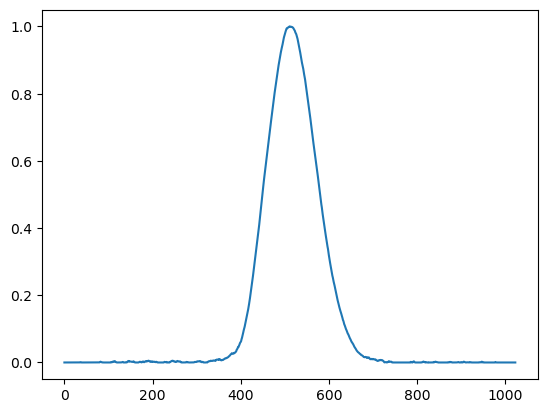

In [9]:
#spectra from data
sss = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Dec/specs_Feb3_110.npy')
sss = np.mean(sss,axis = 0)
sss = sss/np.max(sss)
sss[sss<0] = 0
rollnum = np.argmax(sss)-512
sss = np.roll(sss,-rollnum)
plt.plot(sss)
print(rollnum)

/tmp/ipykernel_10265/2513905298.py:64: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.Qs = np.linalg.lstsq(np.matmul(alpha_t.conj(),alpha_t.T)*(vNaxis['t_sample'][1] - vNaxis['t_sample'][0]),np.matmul(alpha_t.conj(),np.reshape(x,(2801,1))*2*np.pi*(t[1]-t[0])))[0]
/tmp/ipykernel_10265/2008784457.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (13,4))


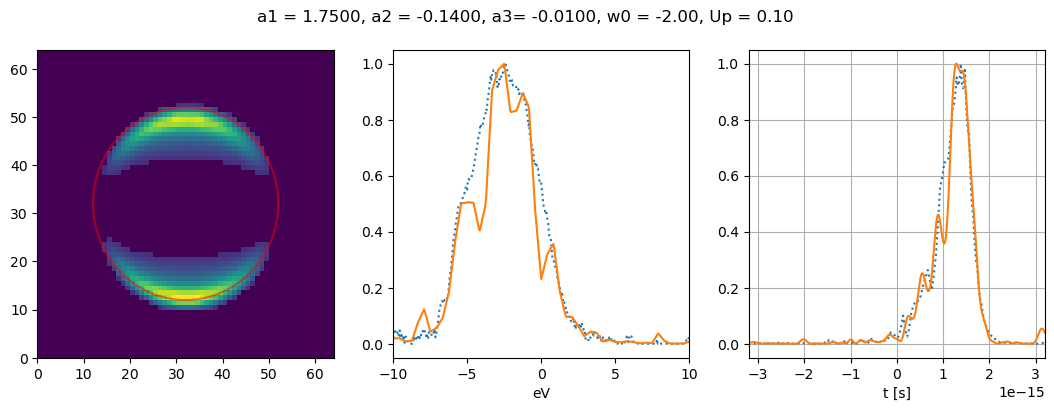

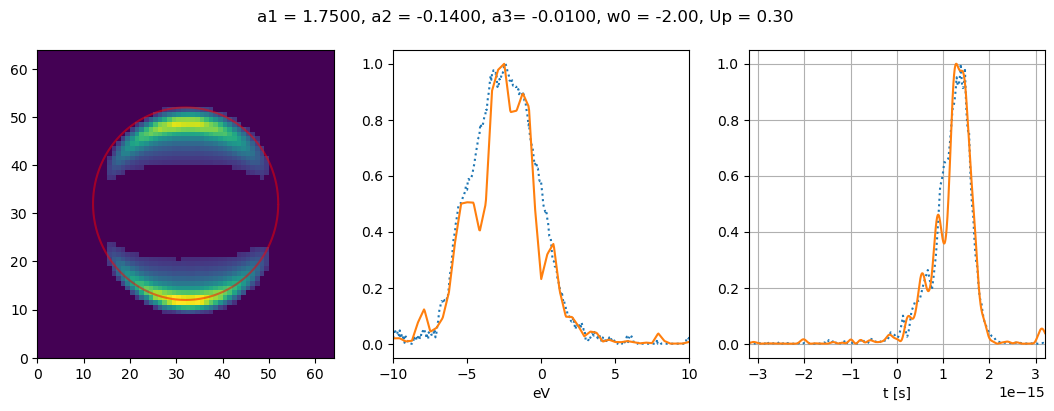

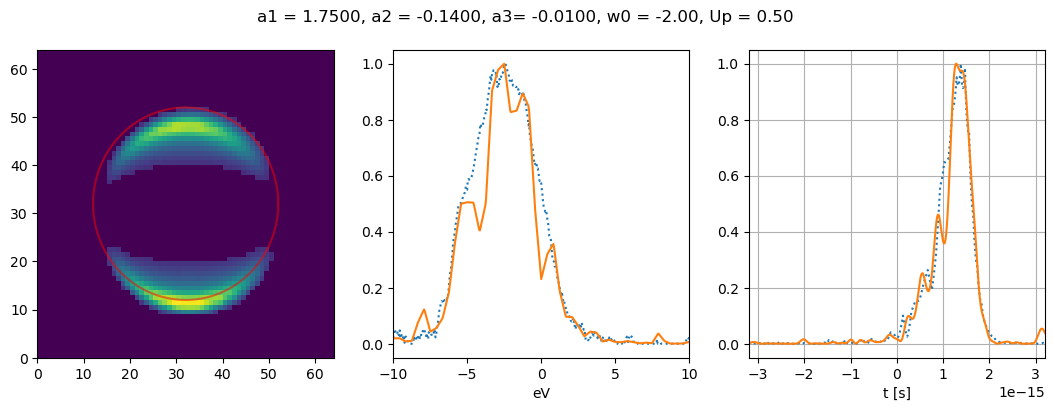

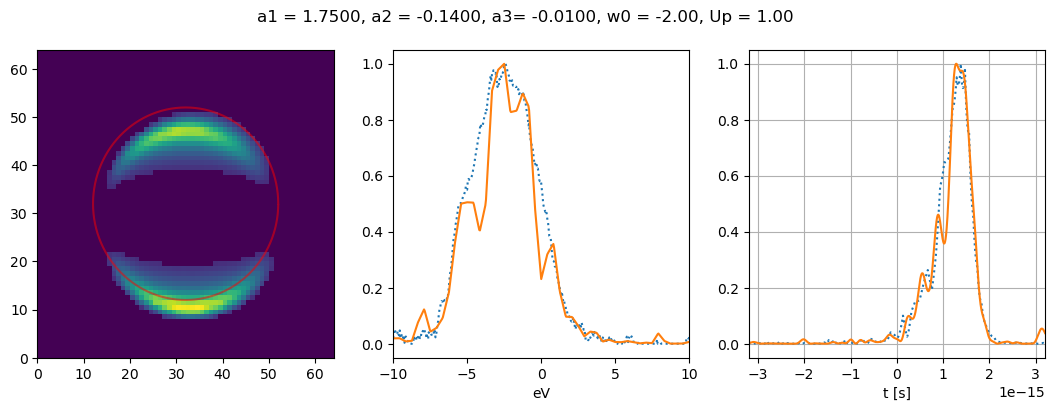

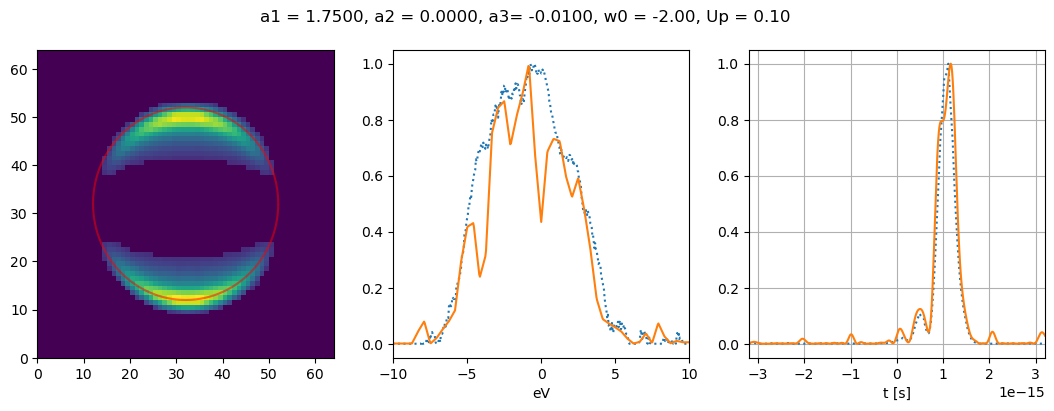

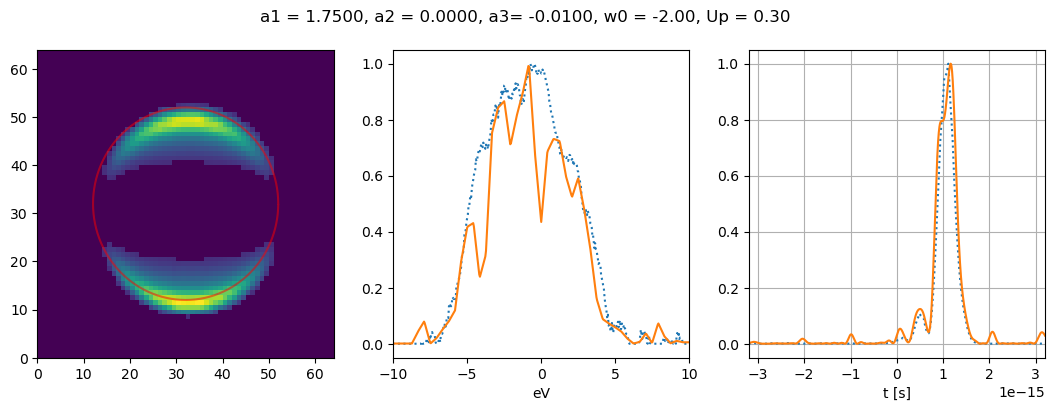

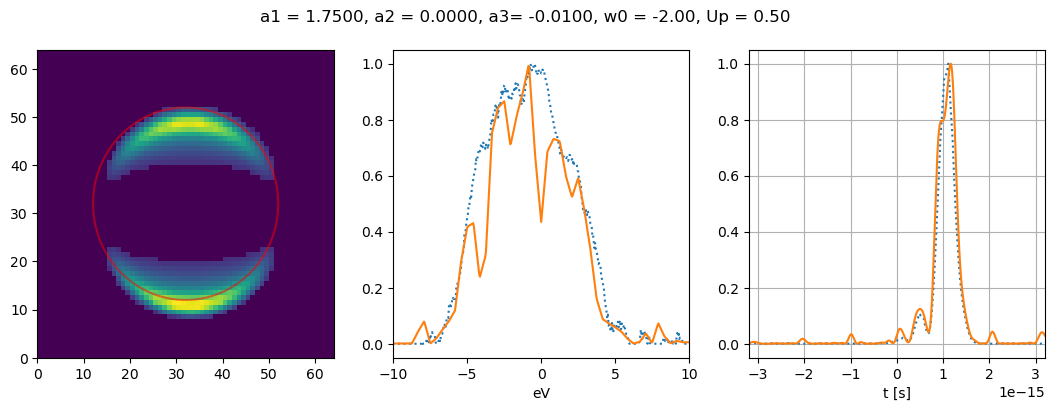

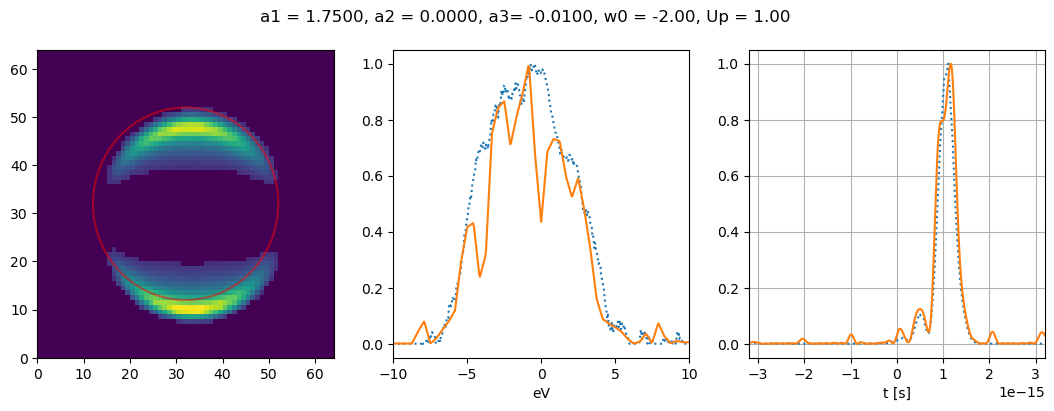

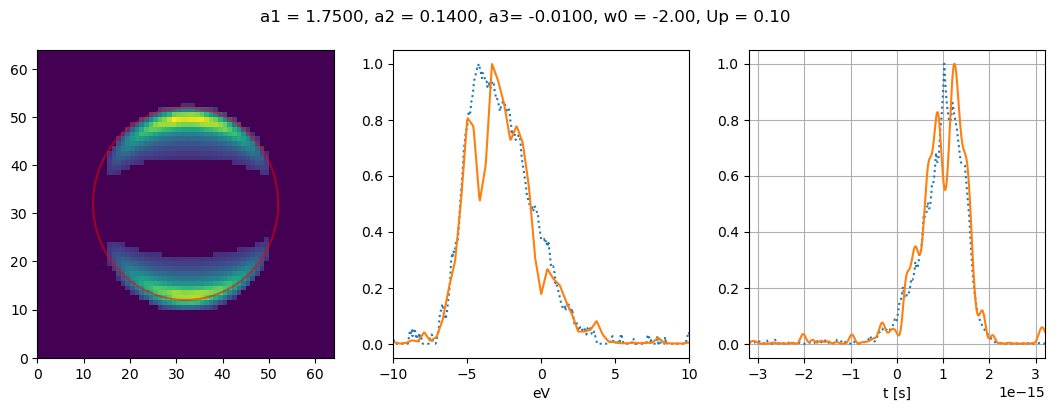

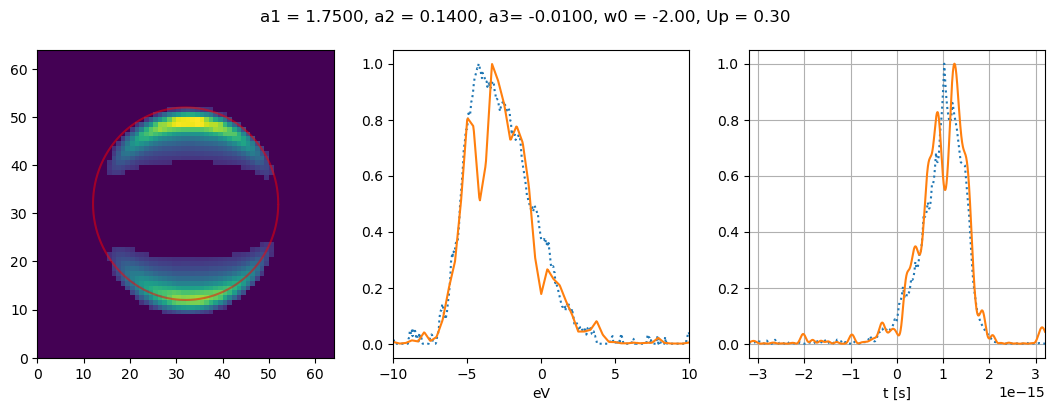

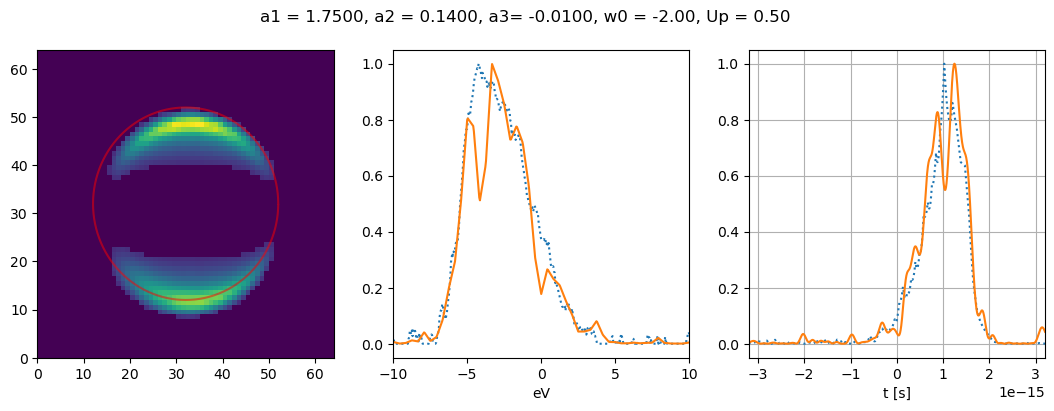

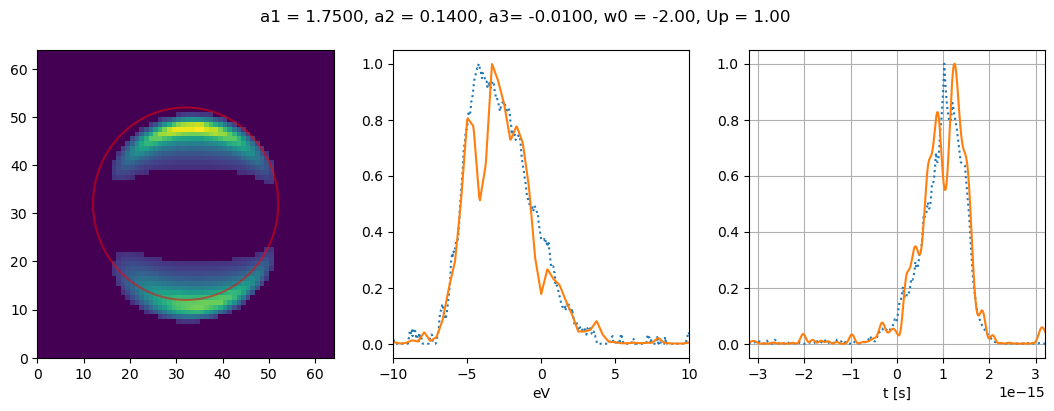

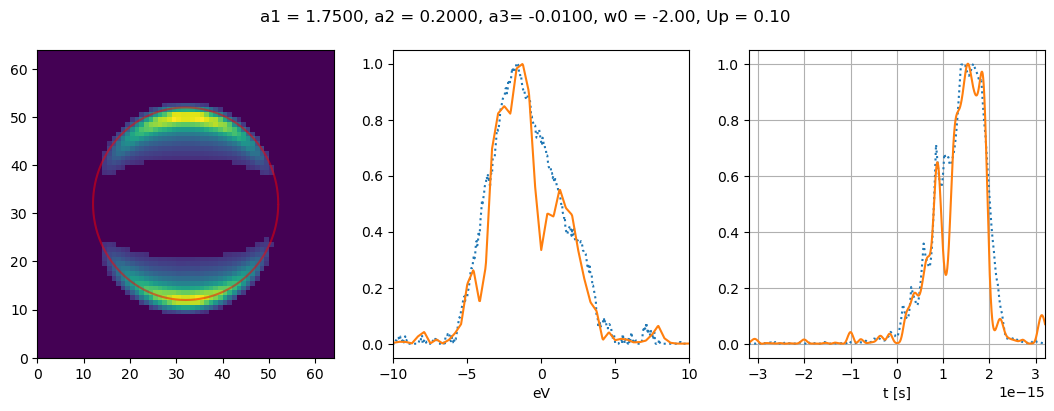

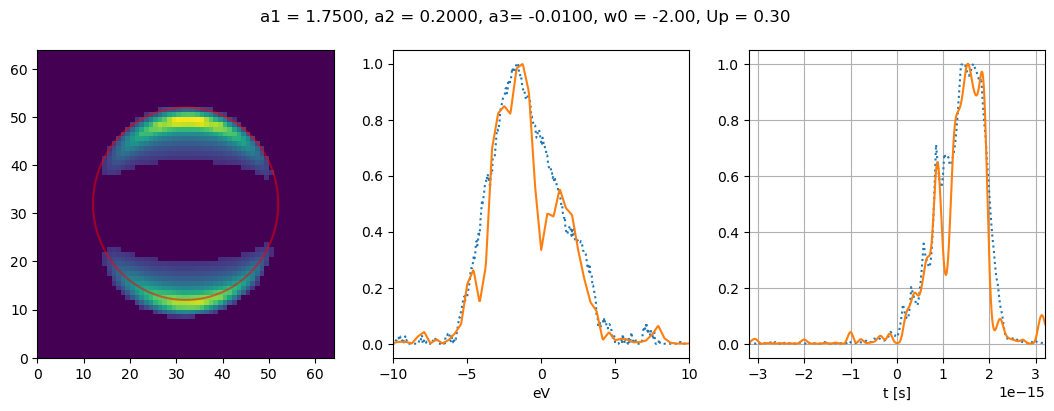

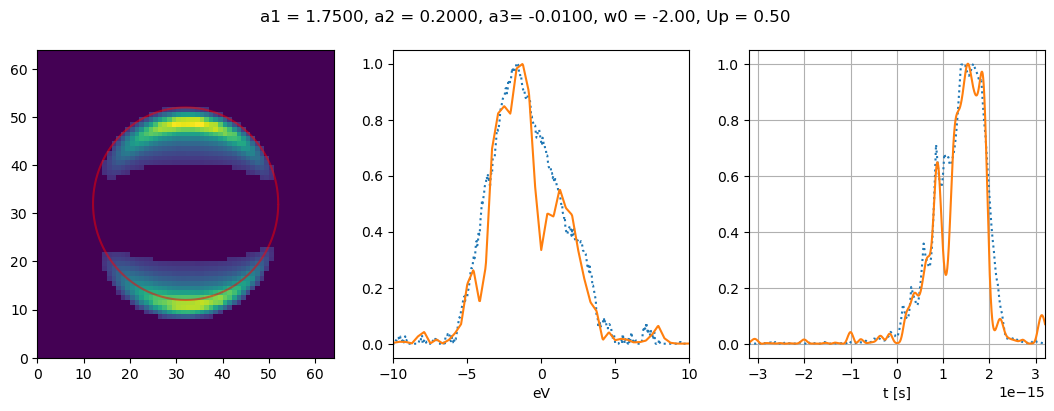

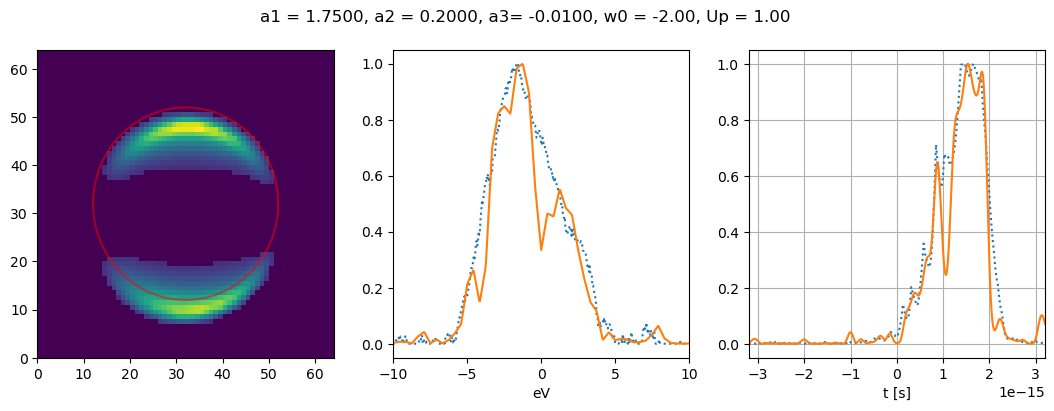

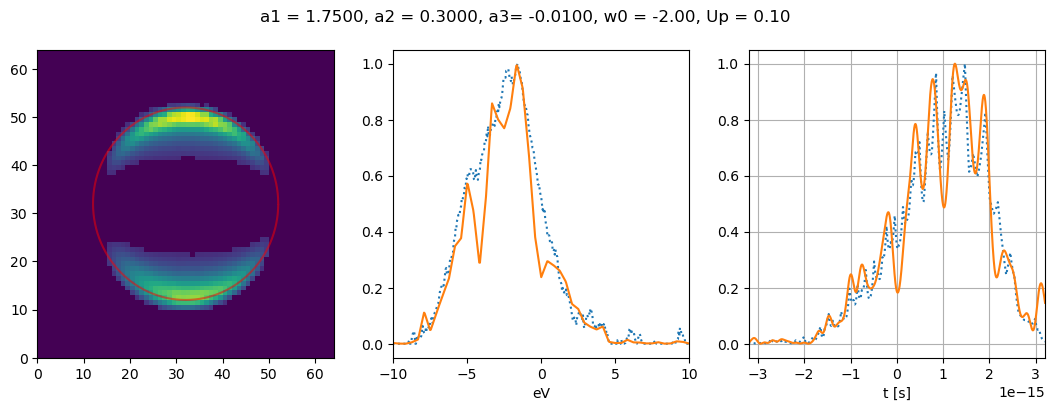

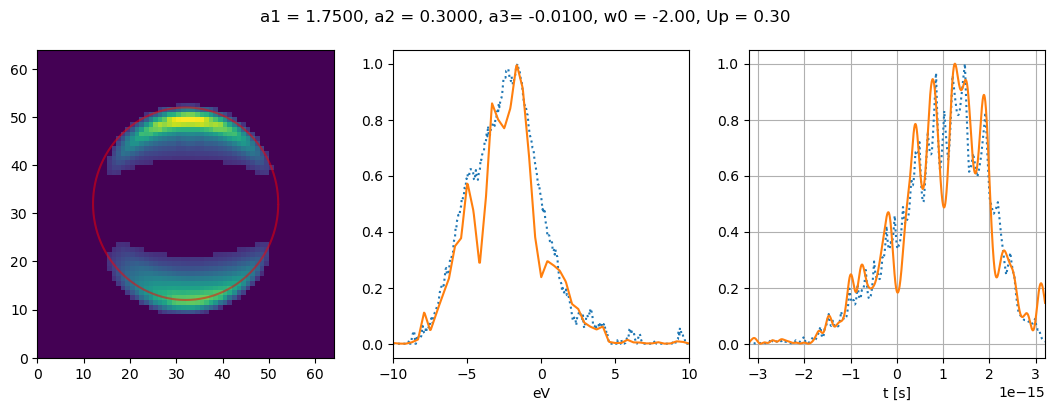

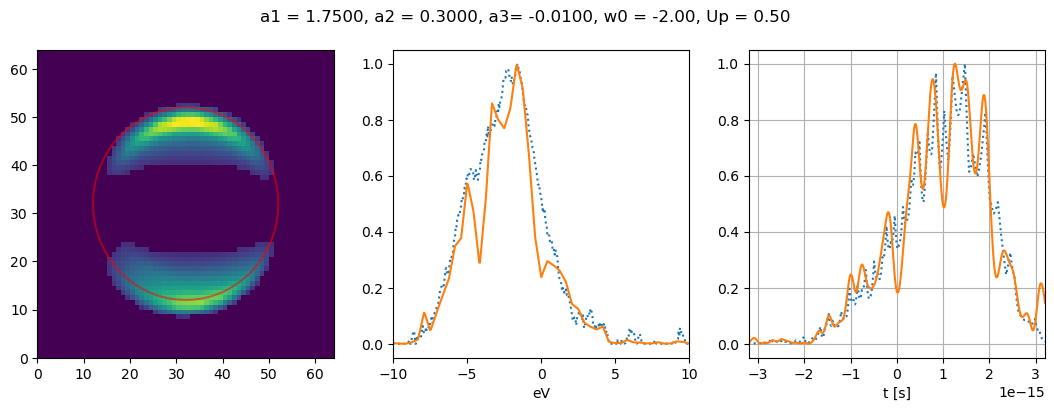

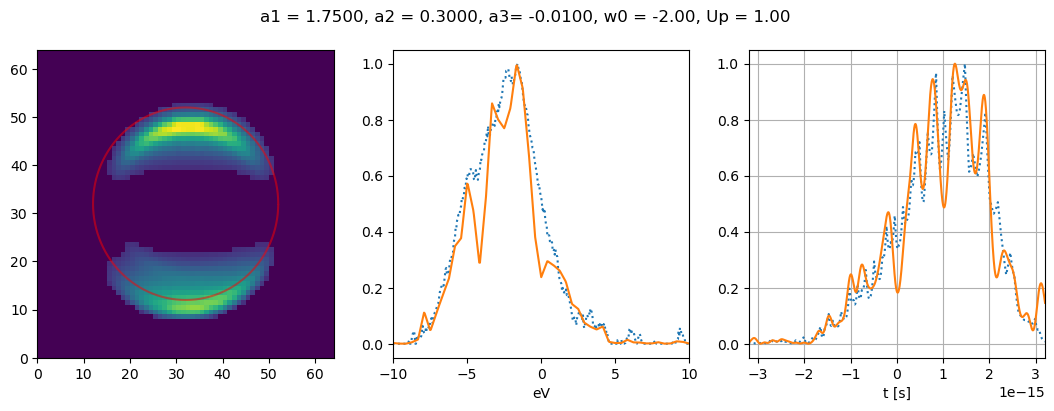

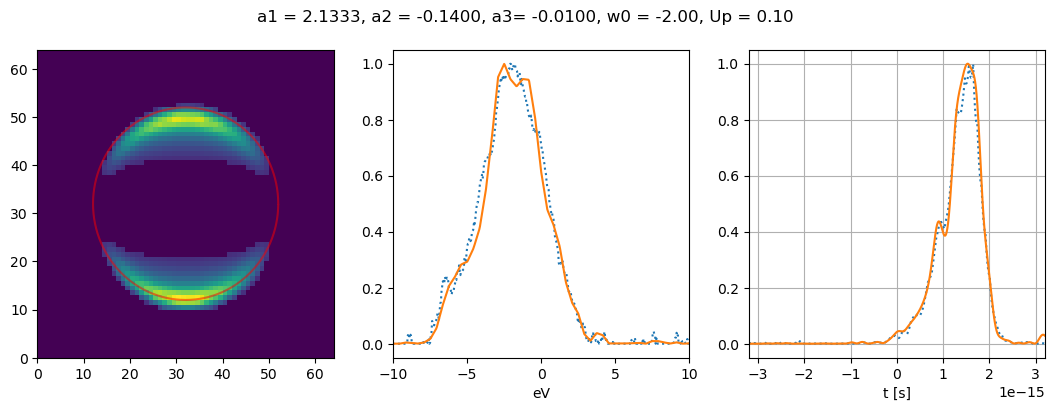

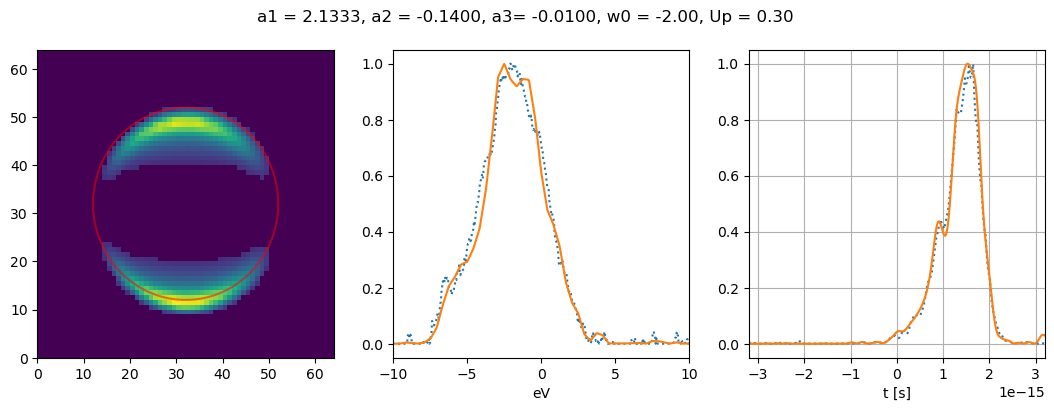

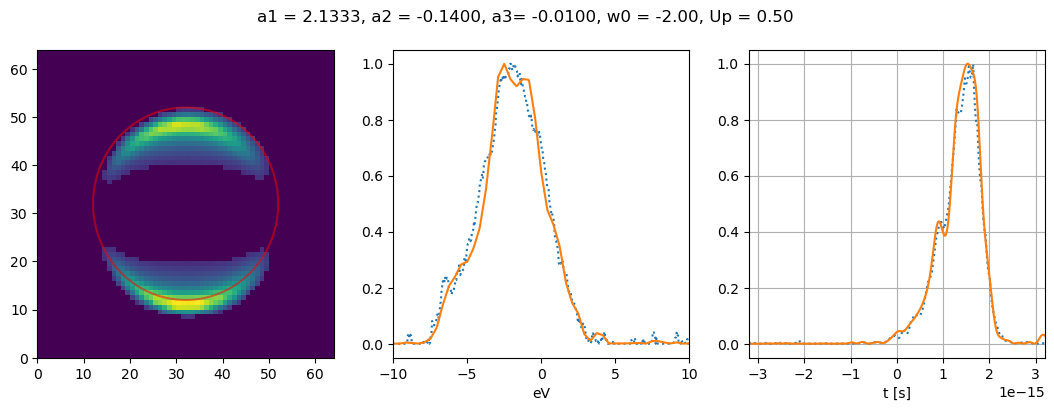

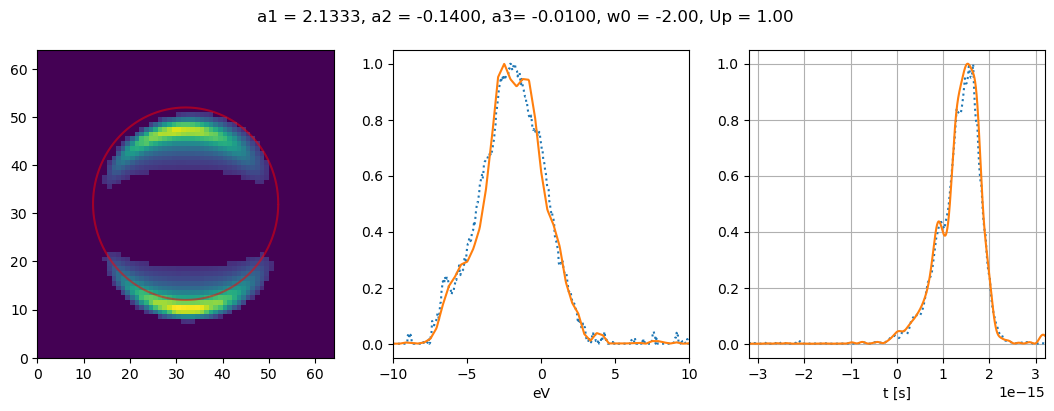

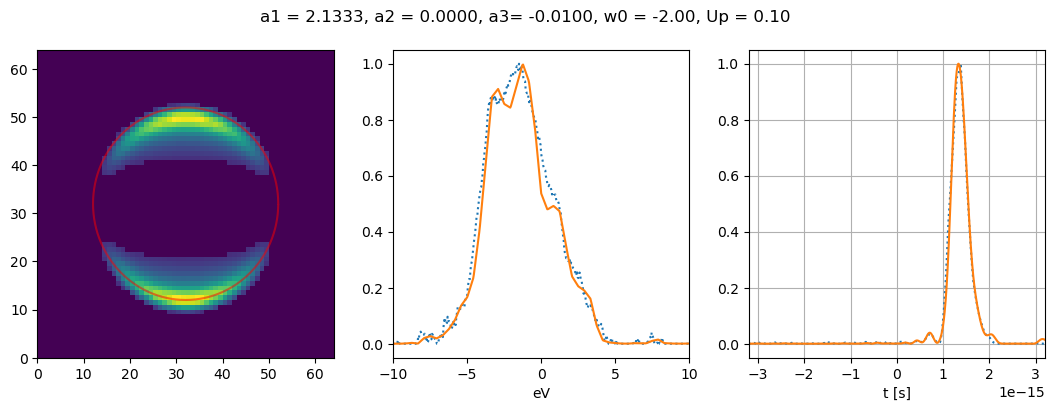

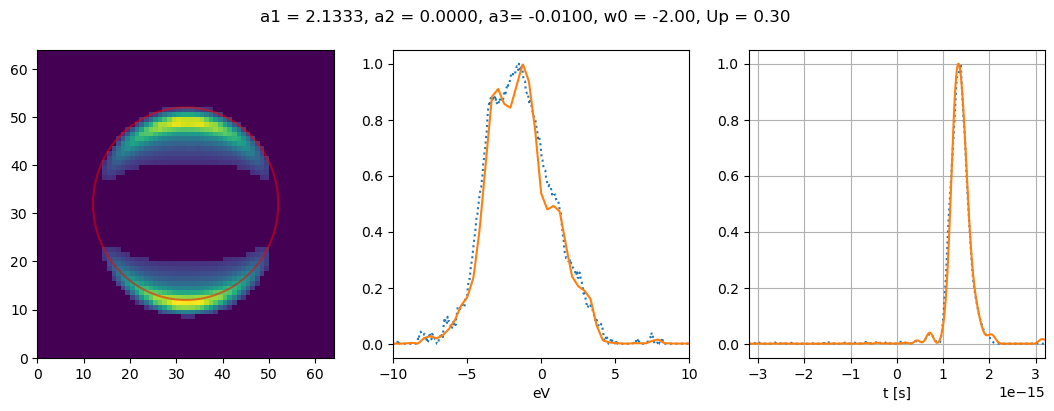

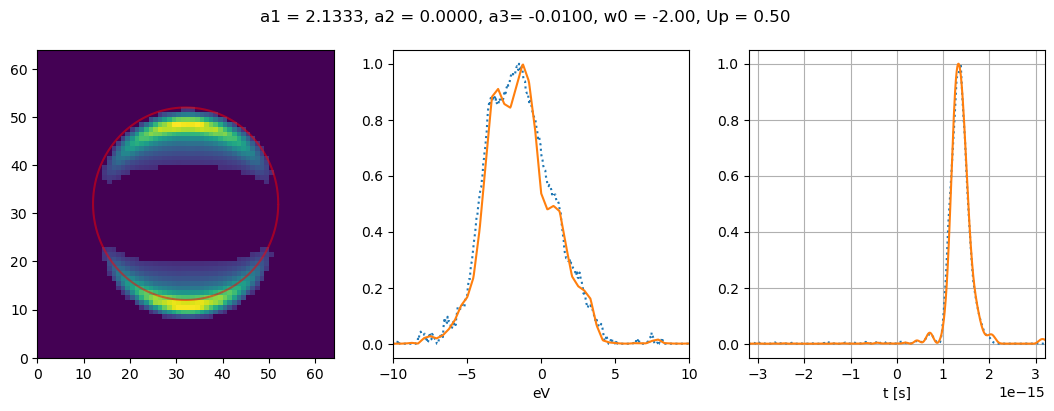

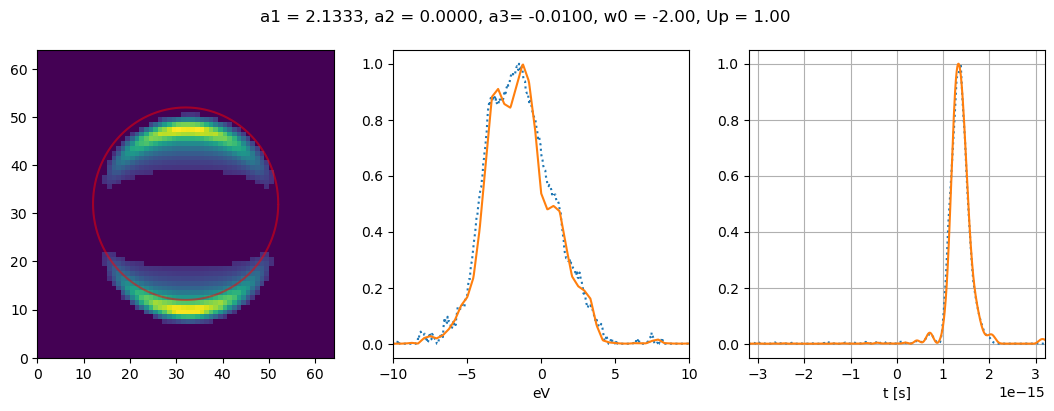

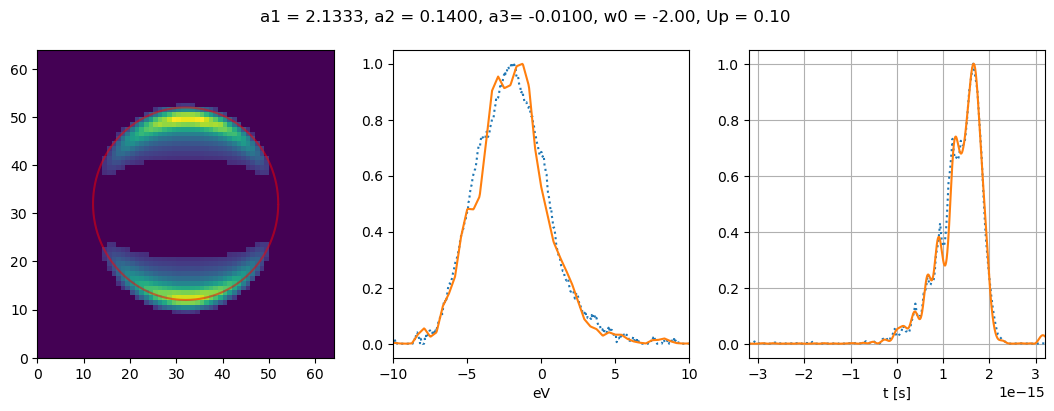

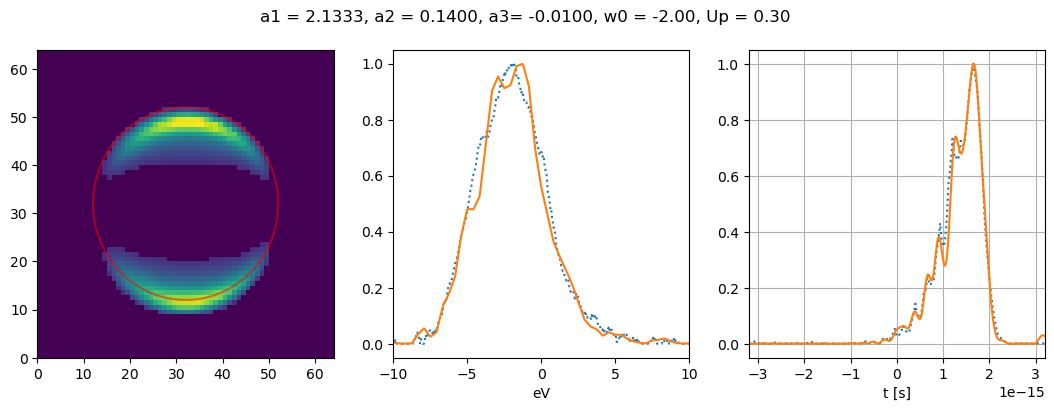

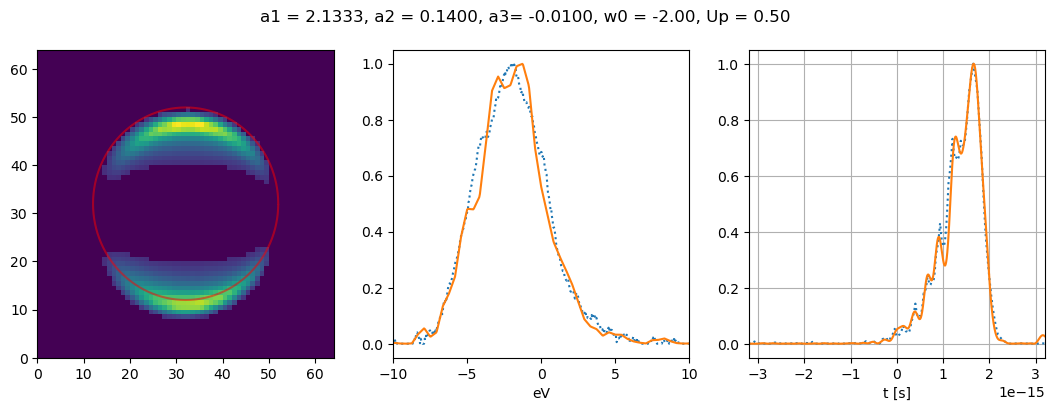

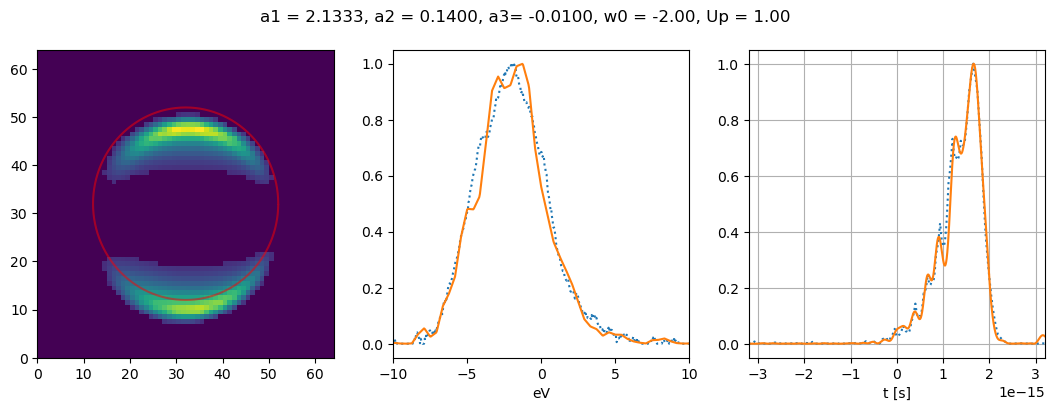

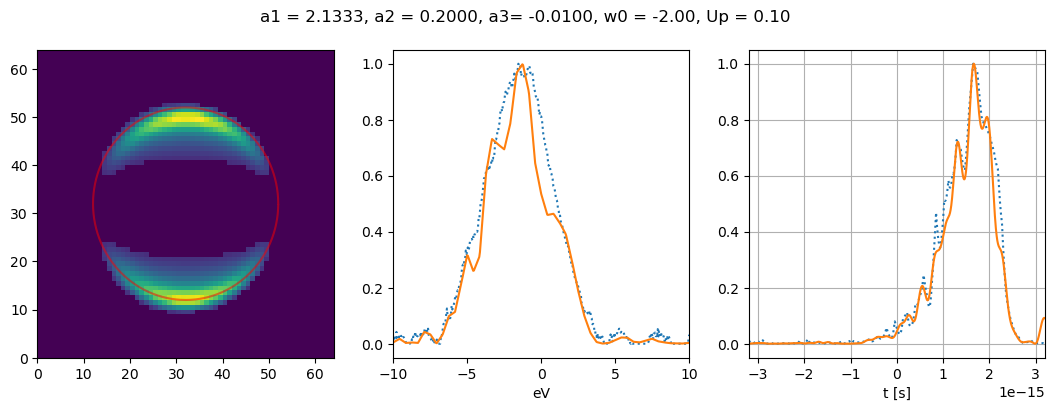

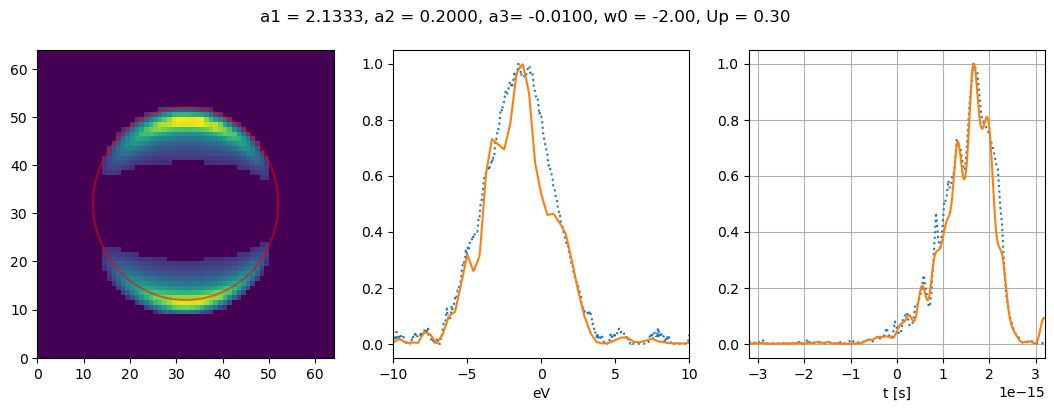

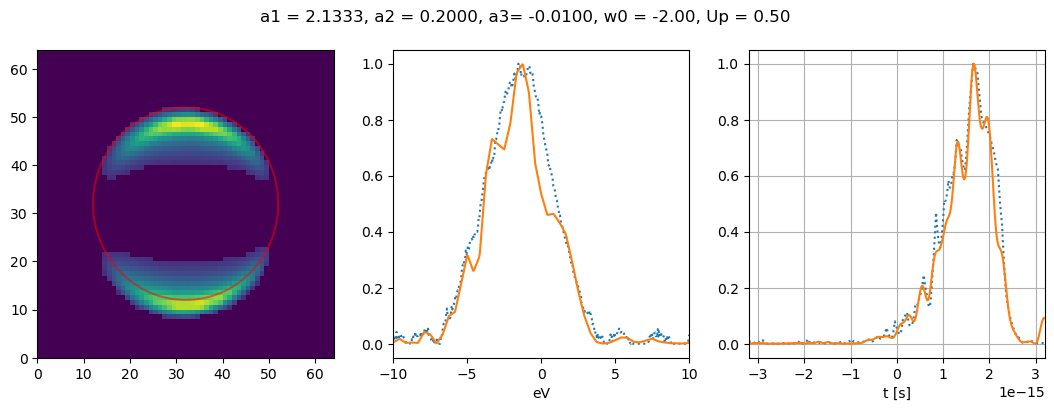

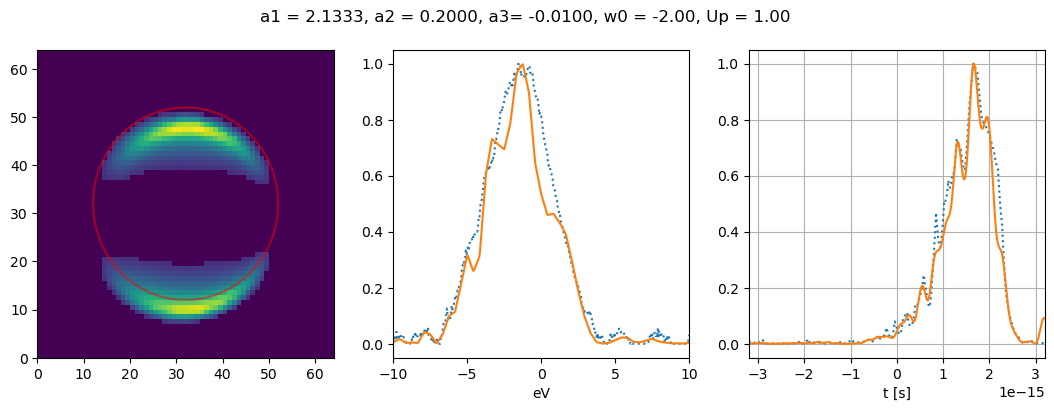

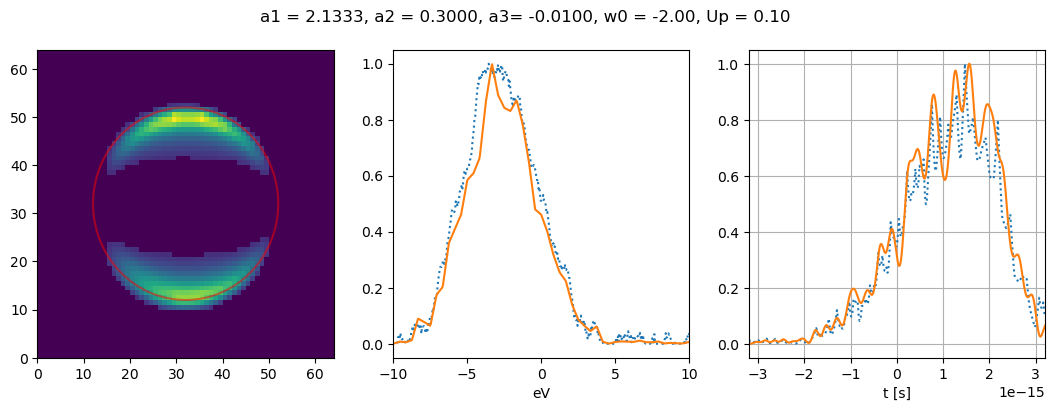

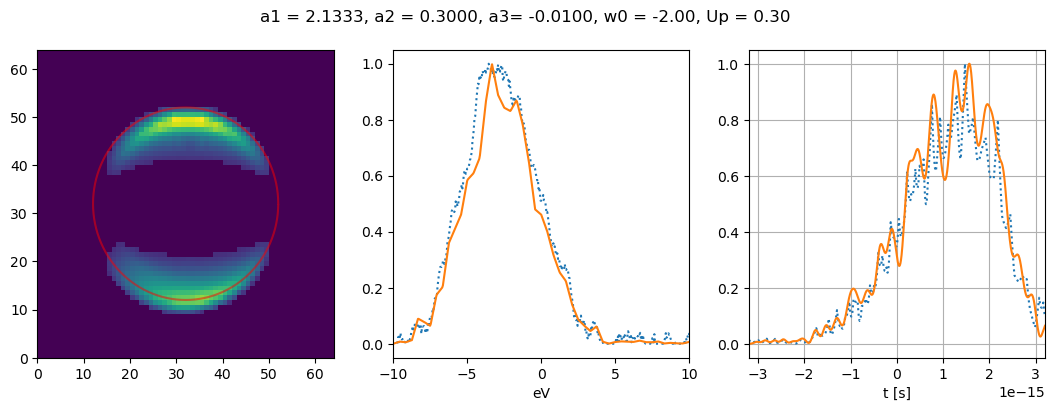

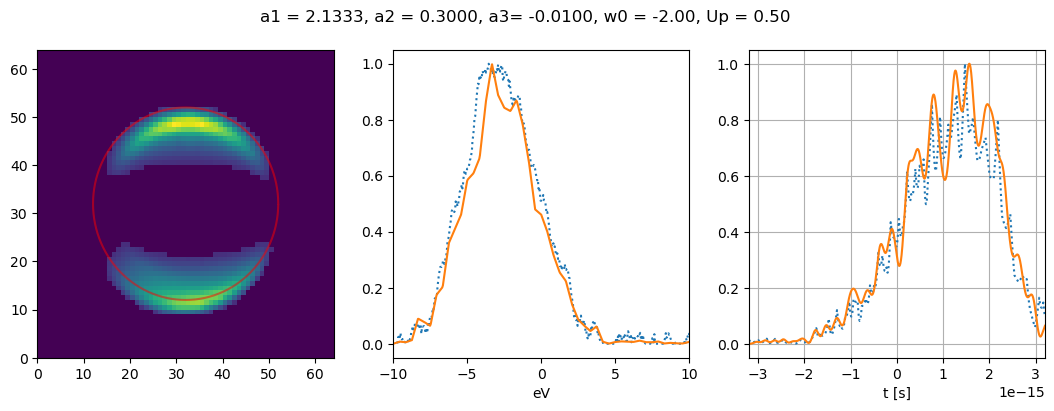

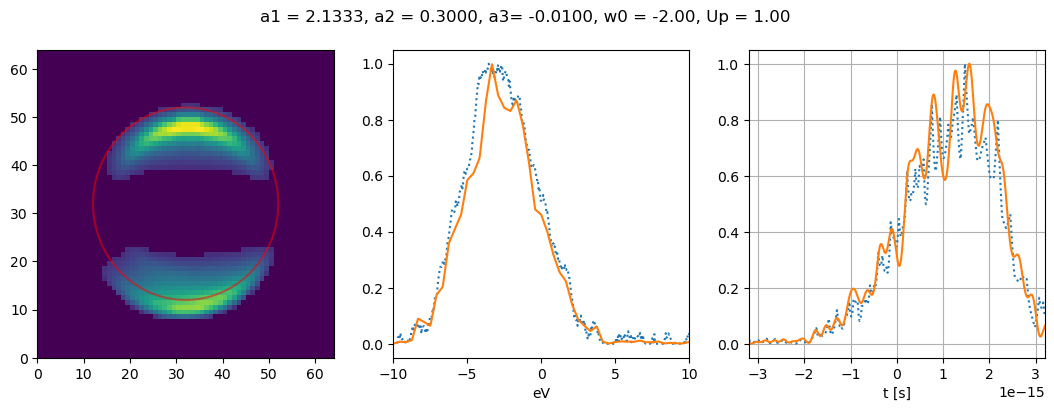

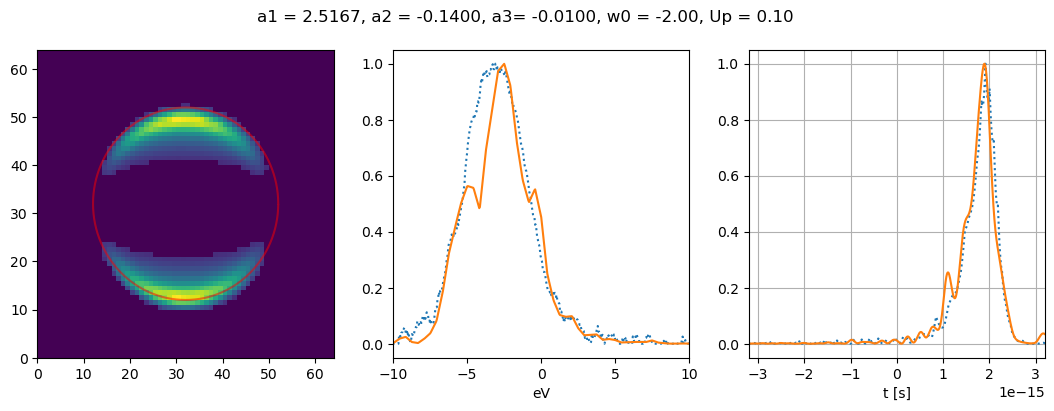

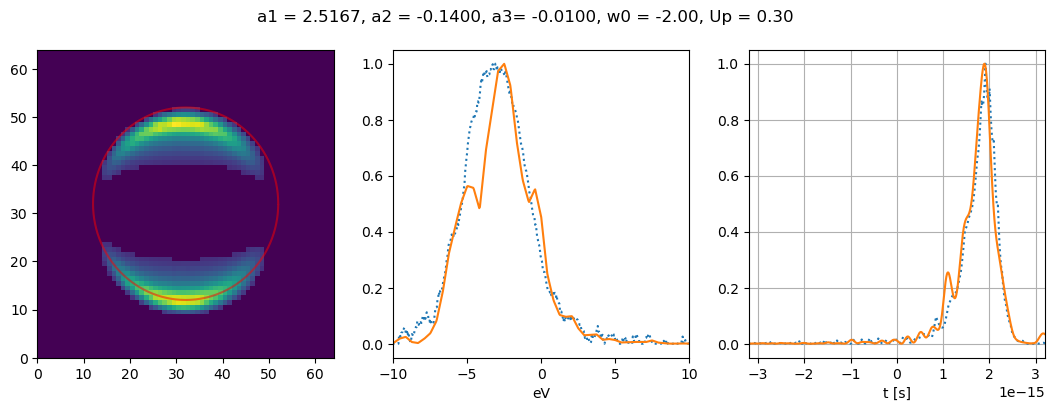

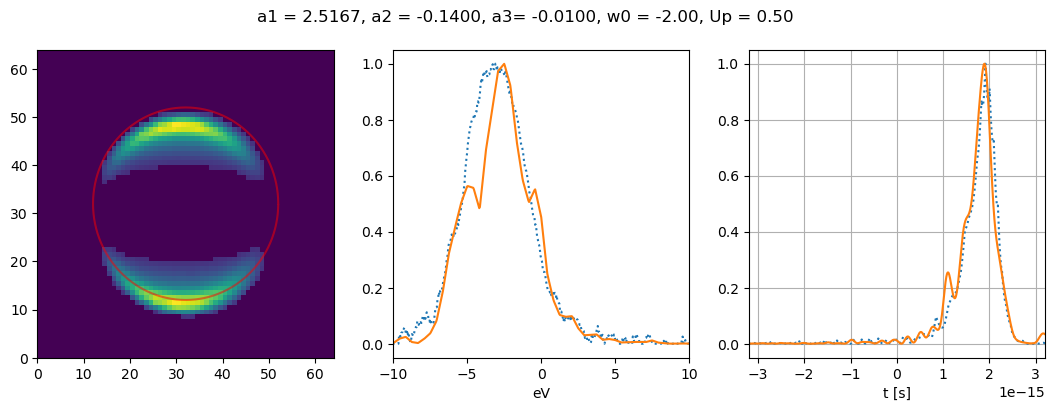

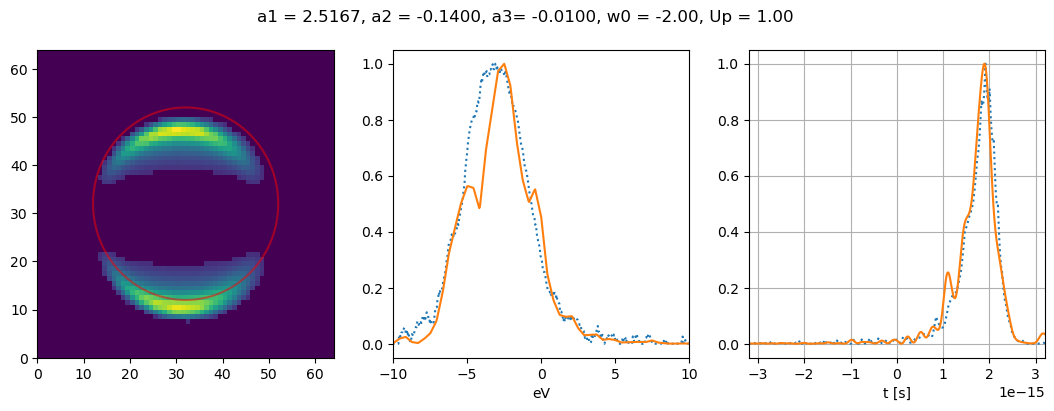

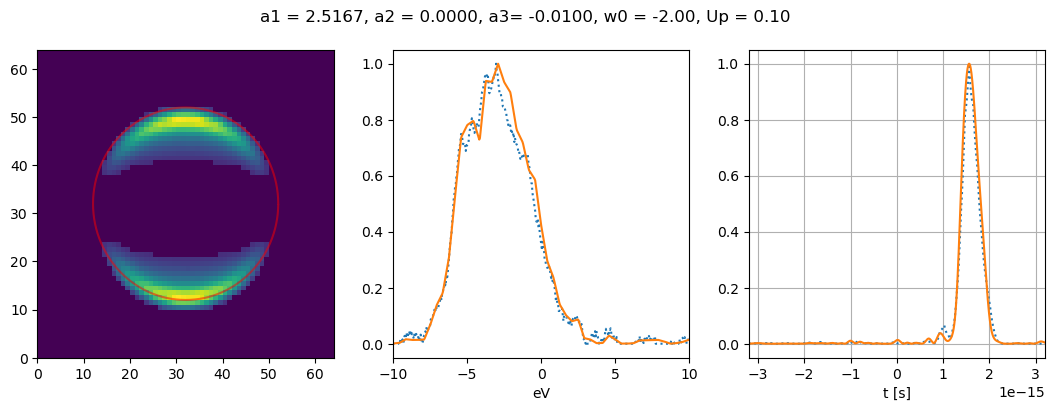

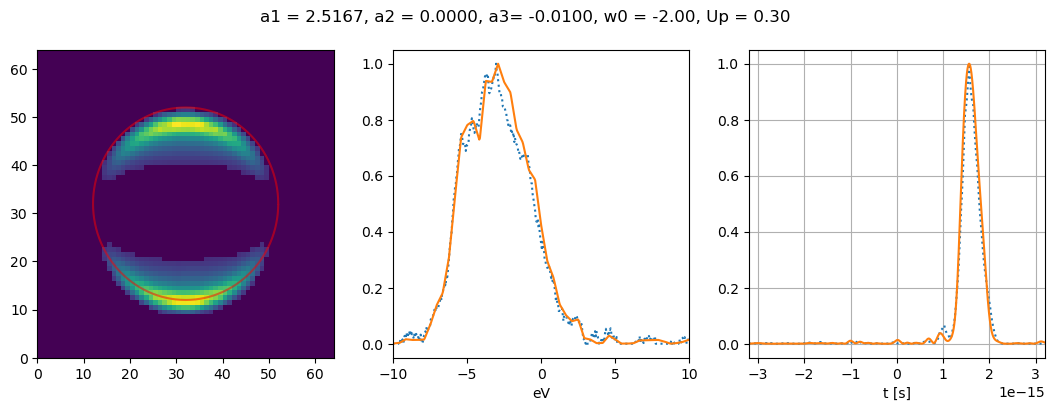

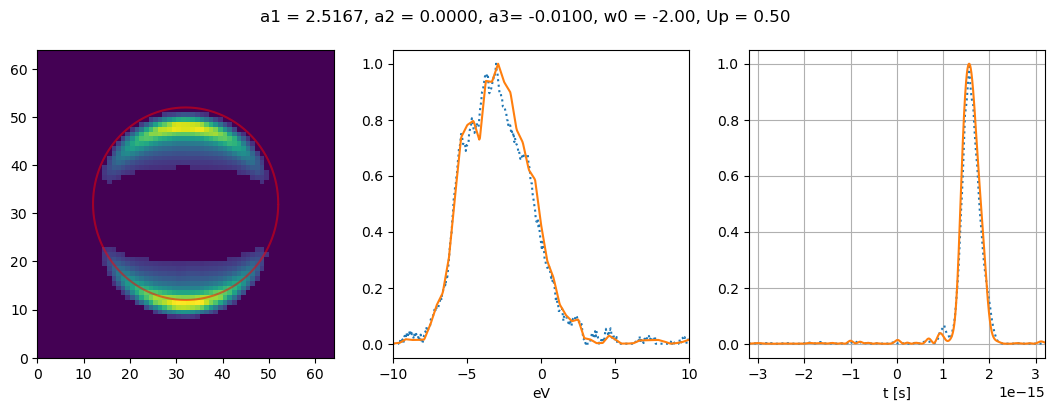

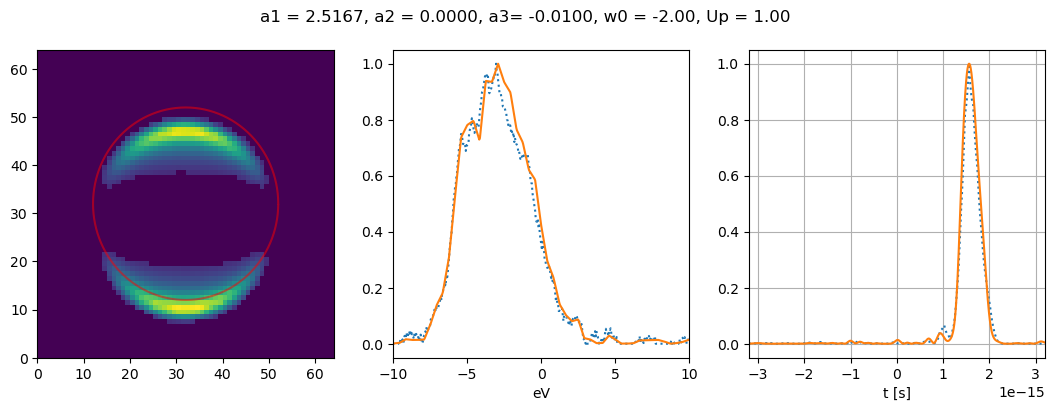

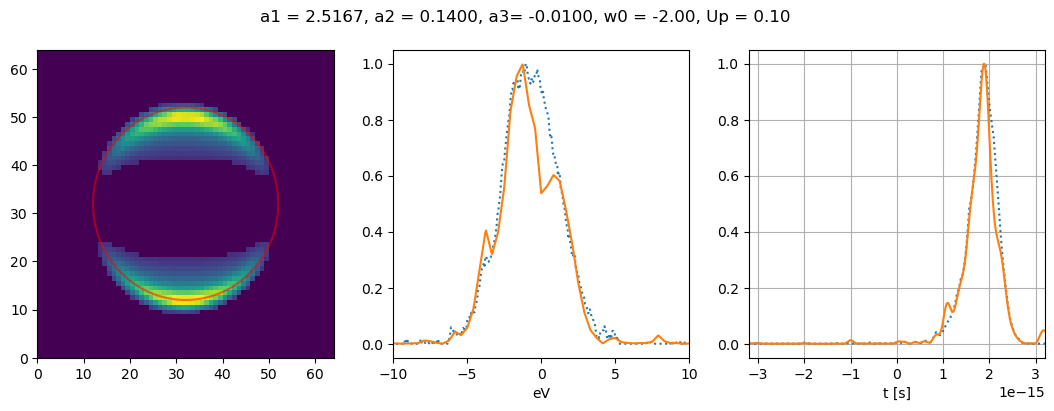

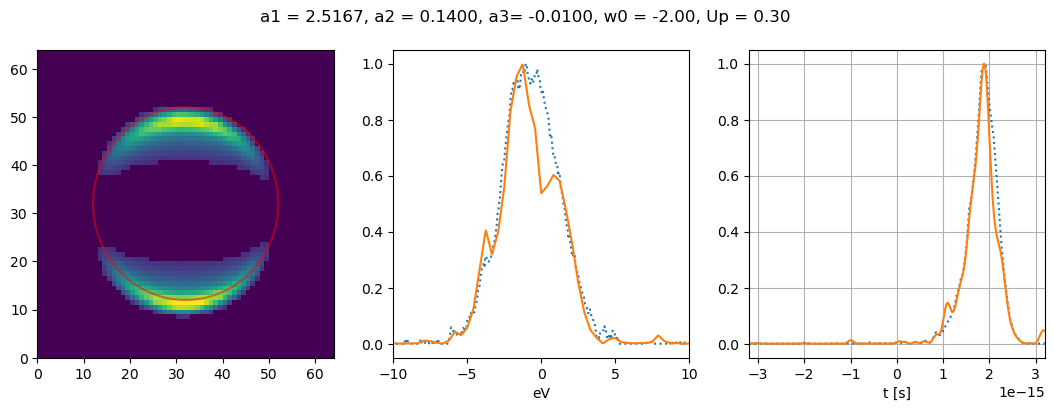

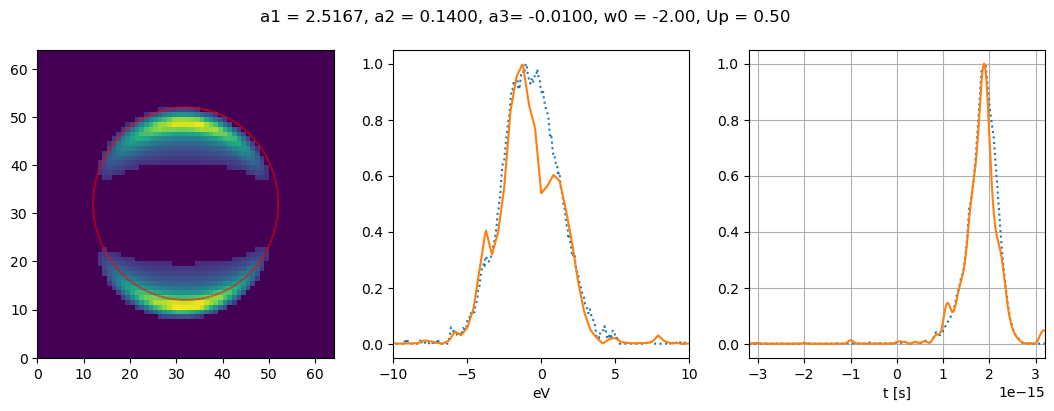

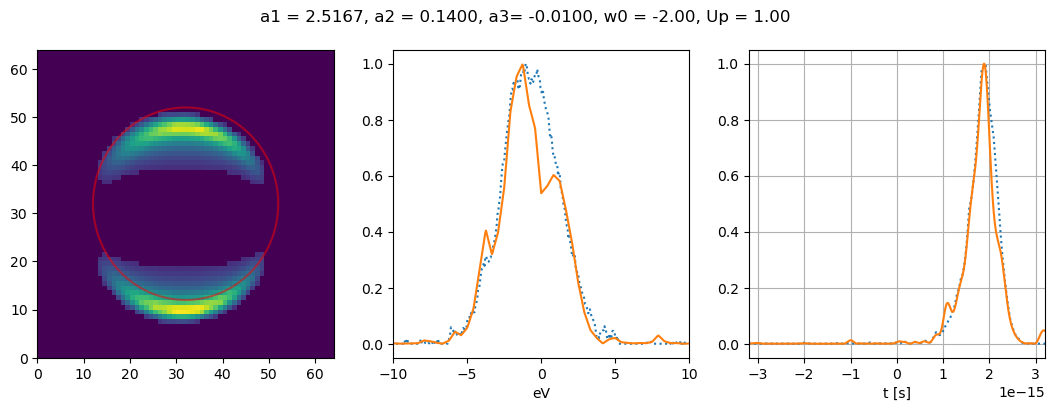

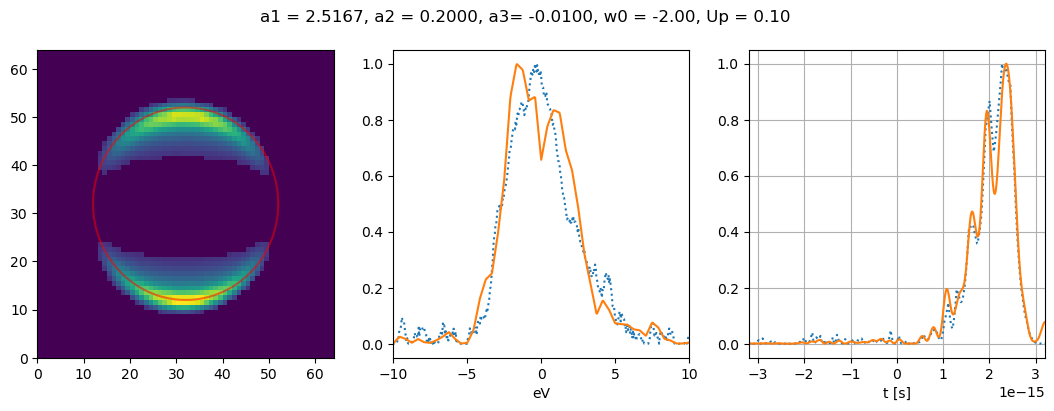

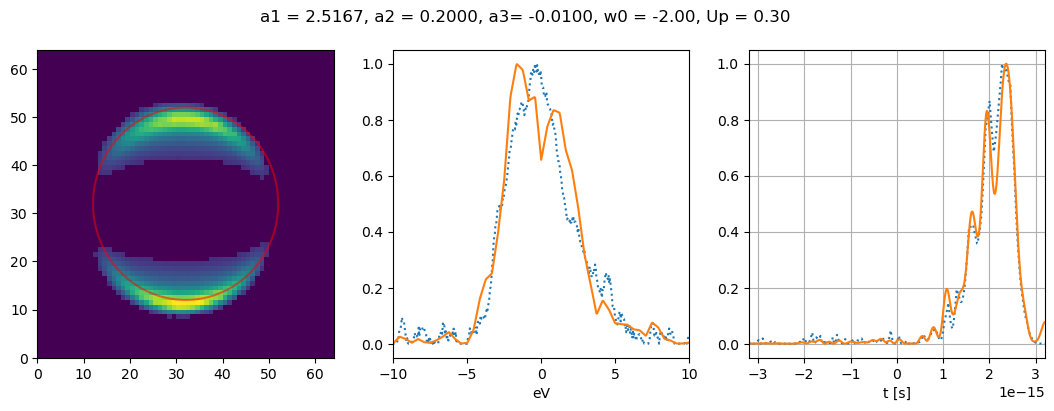

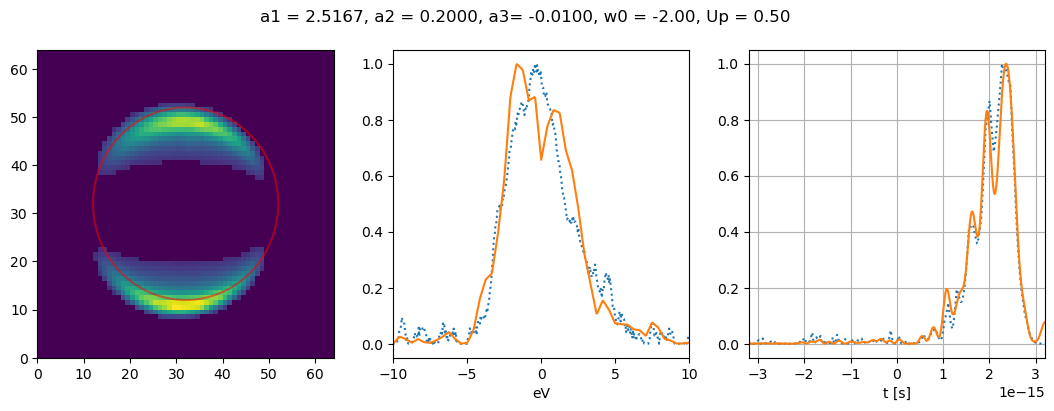

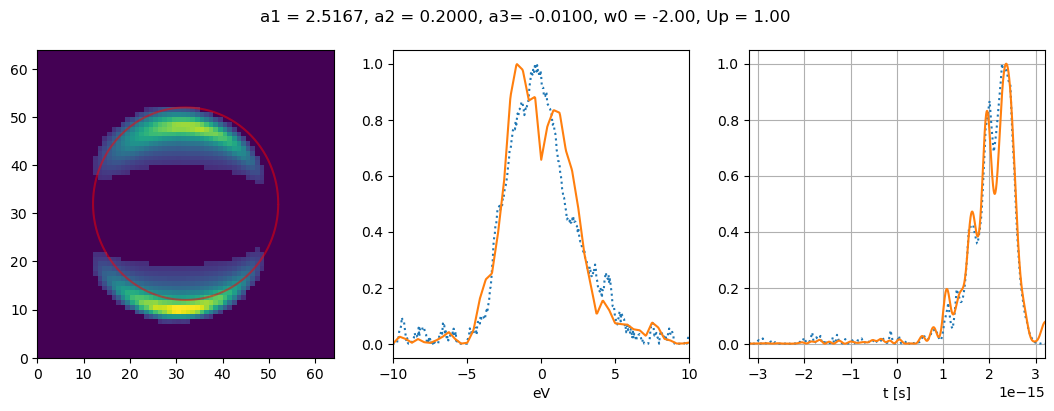

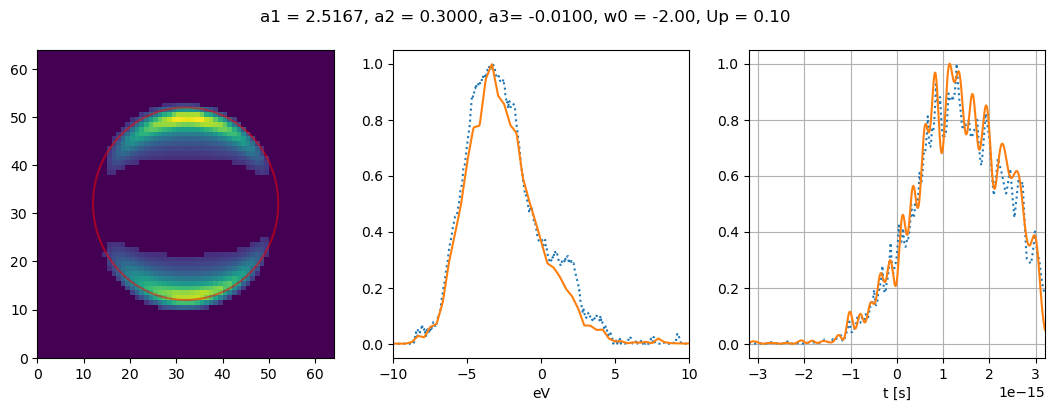

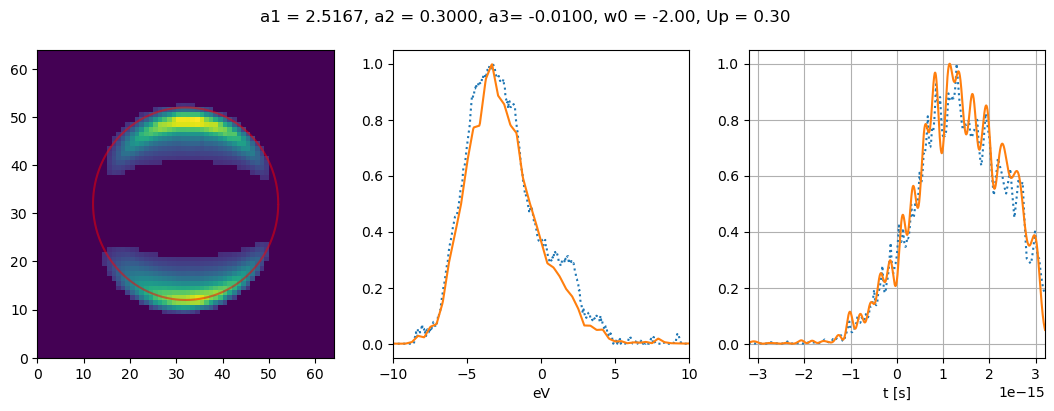

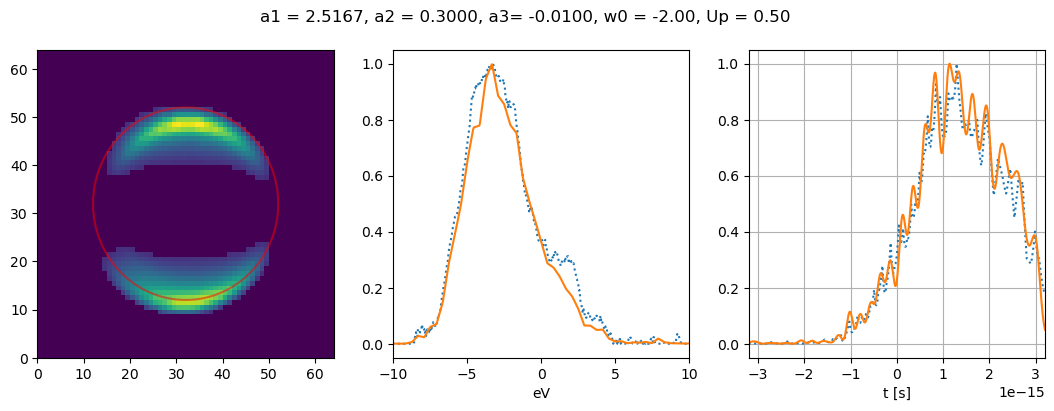

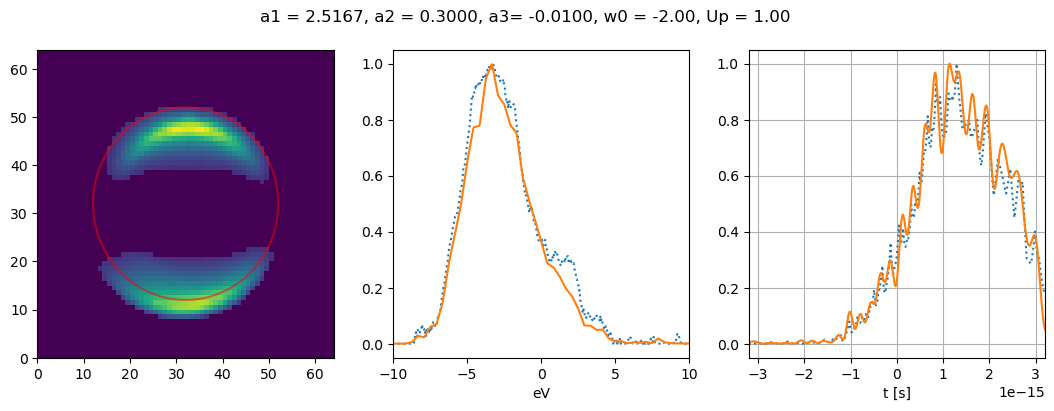

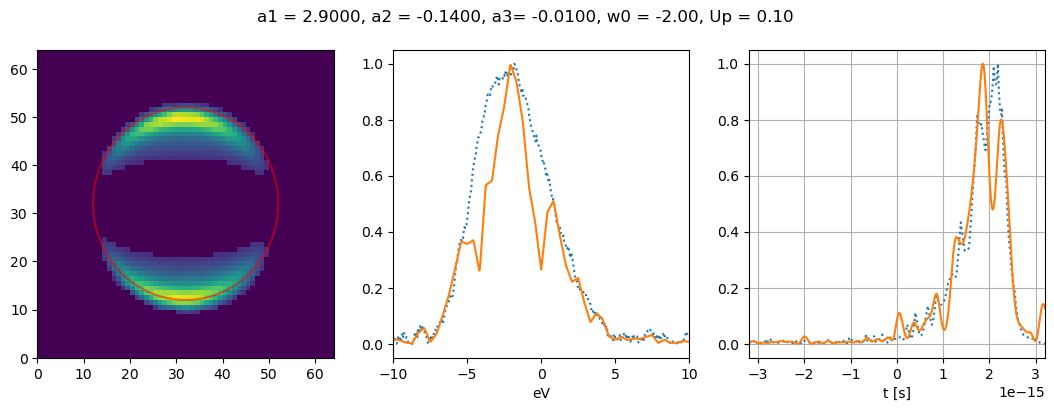

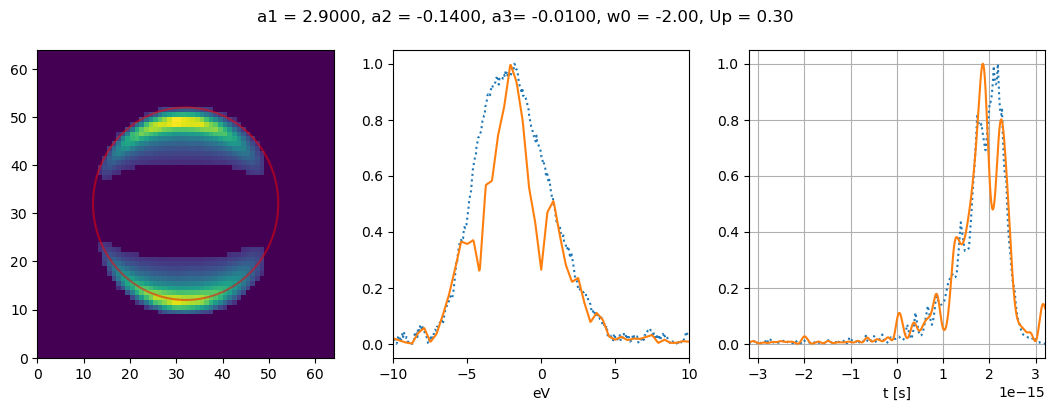

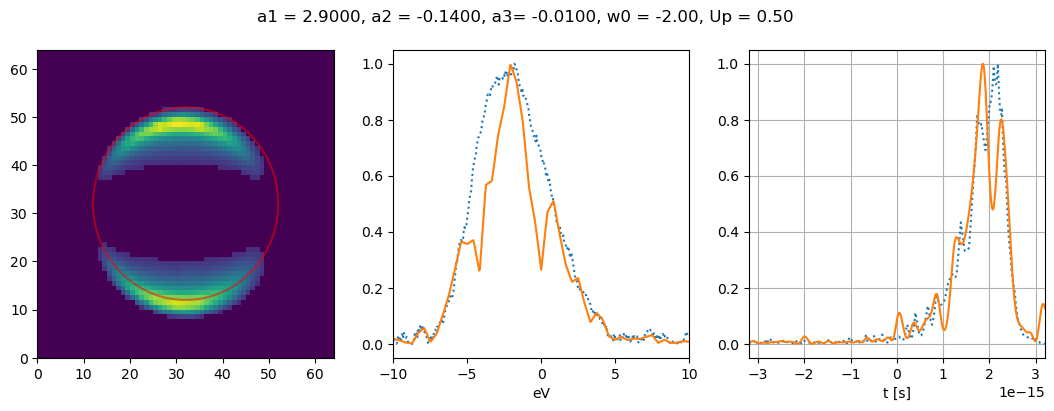

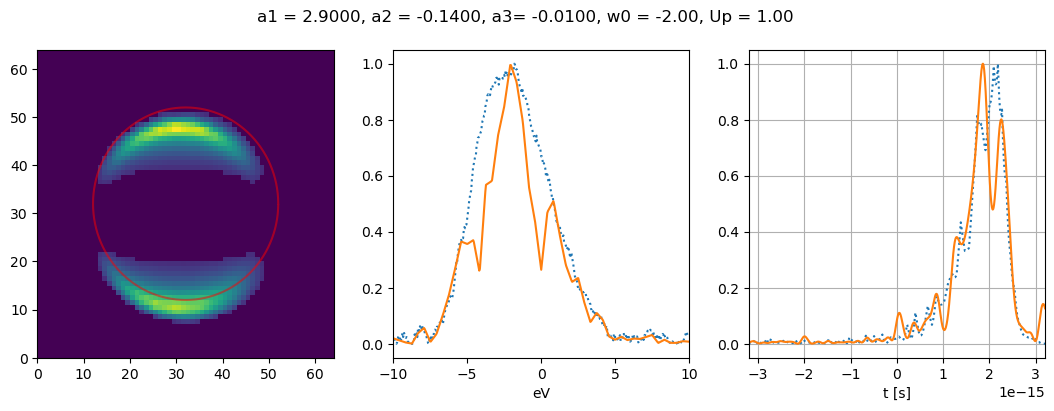

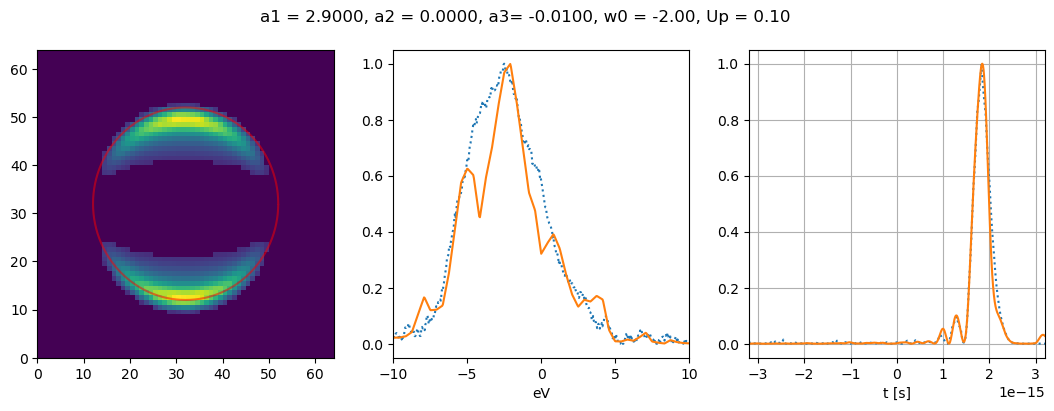

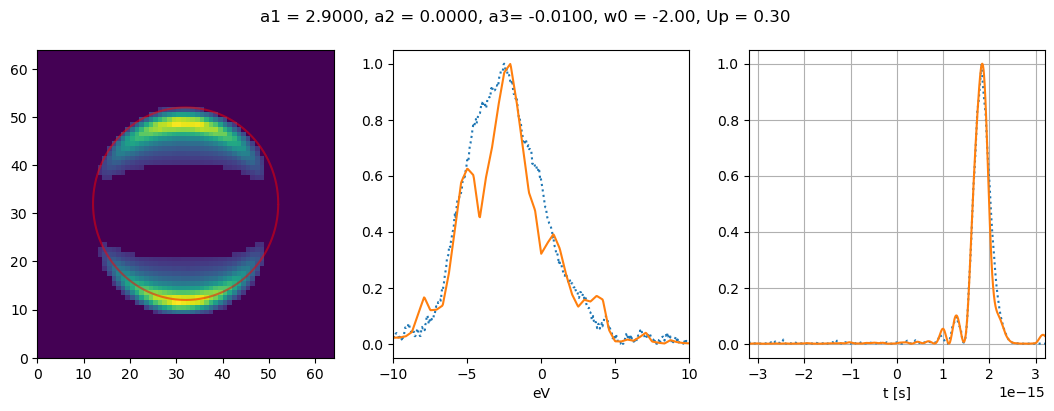

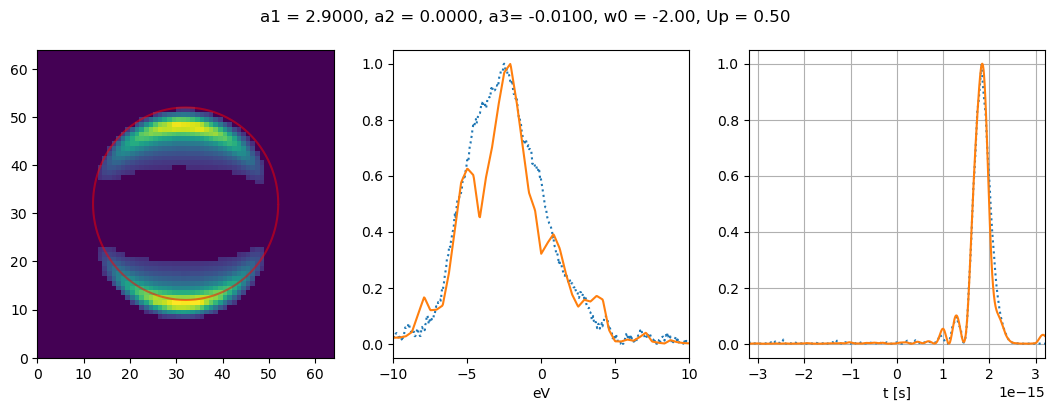

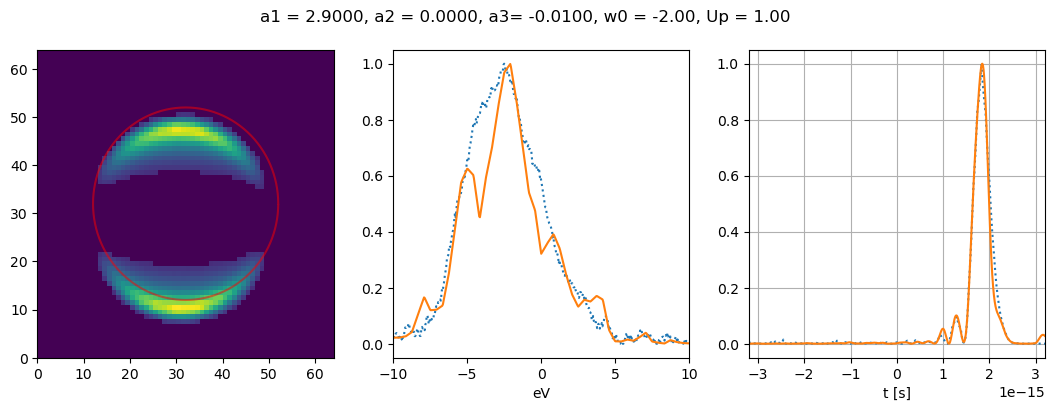

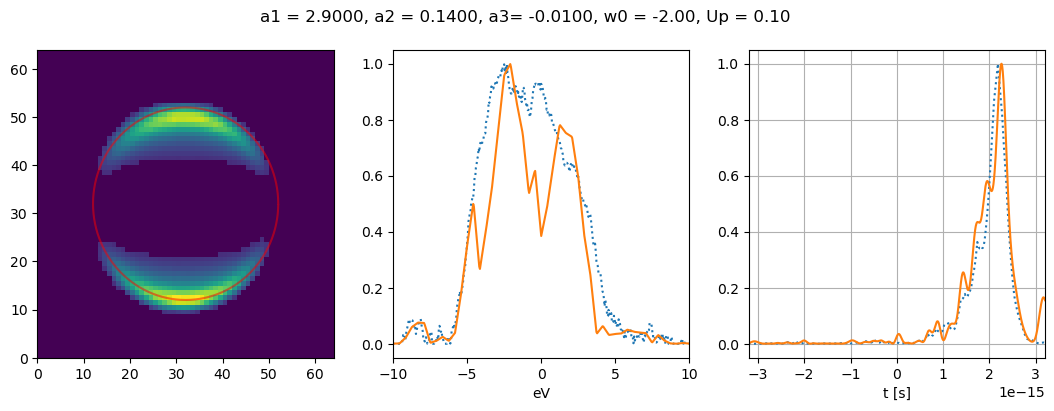

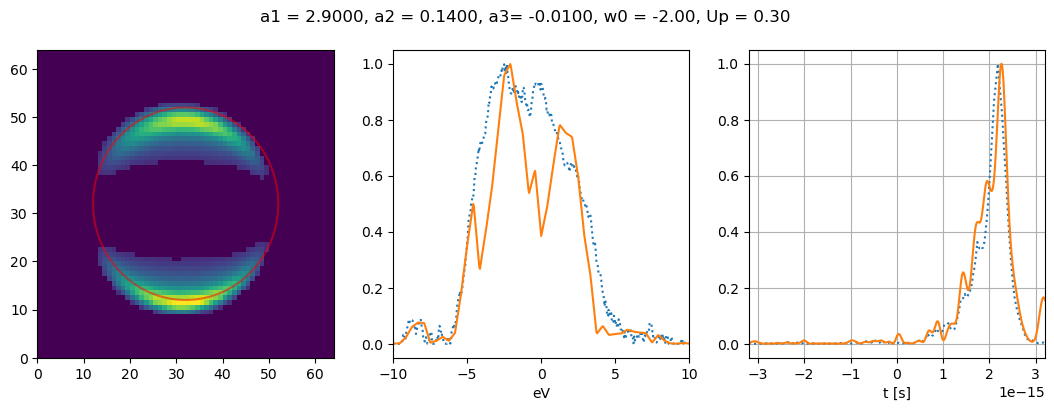

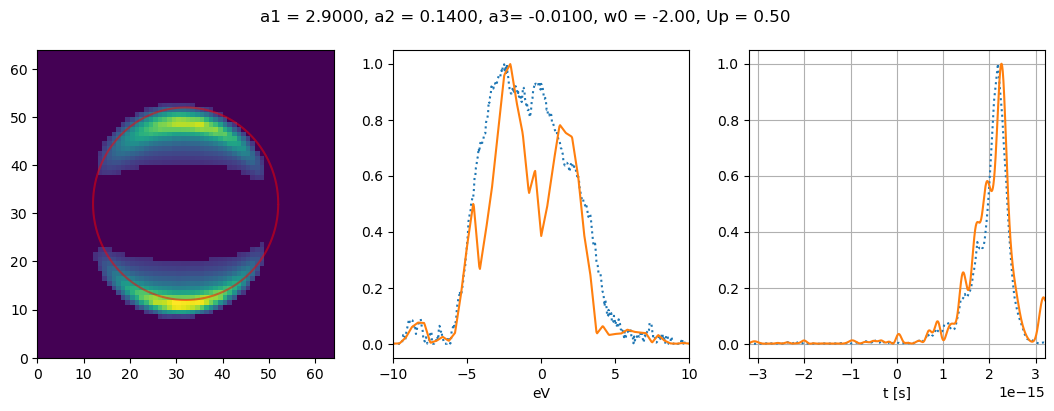

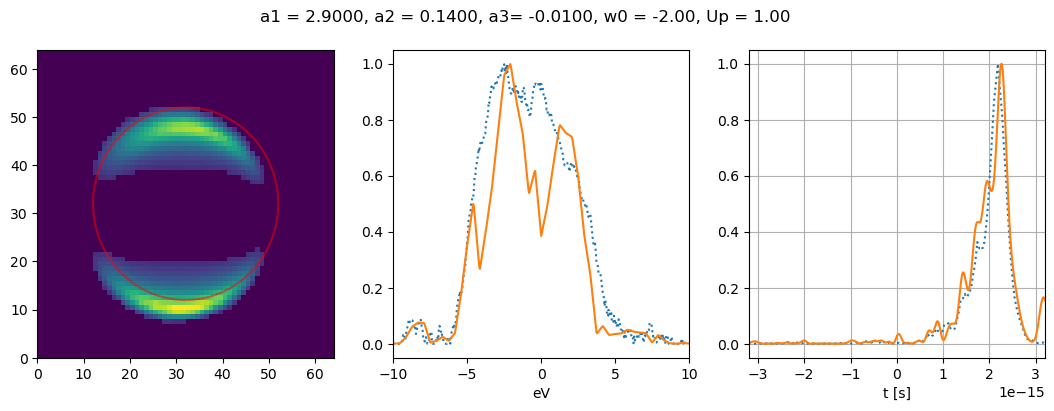

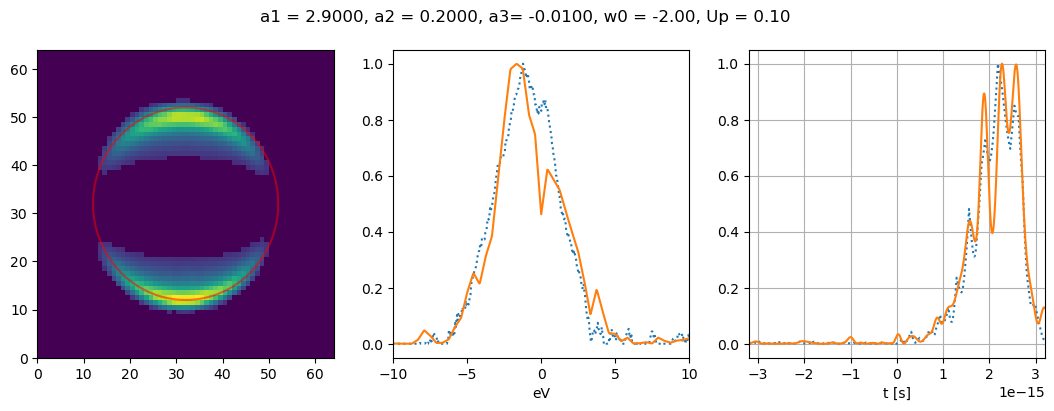

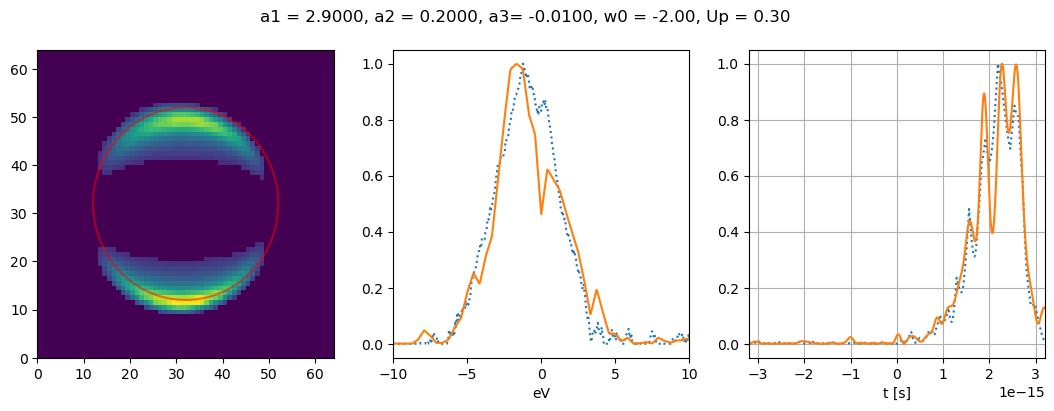

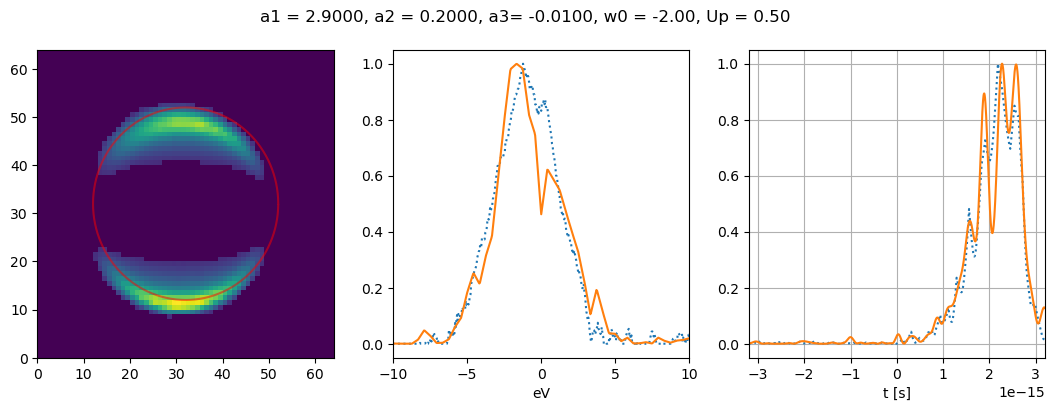

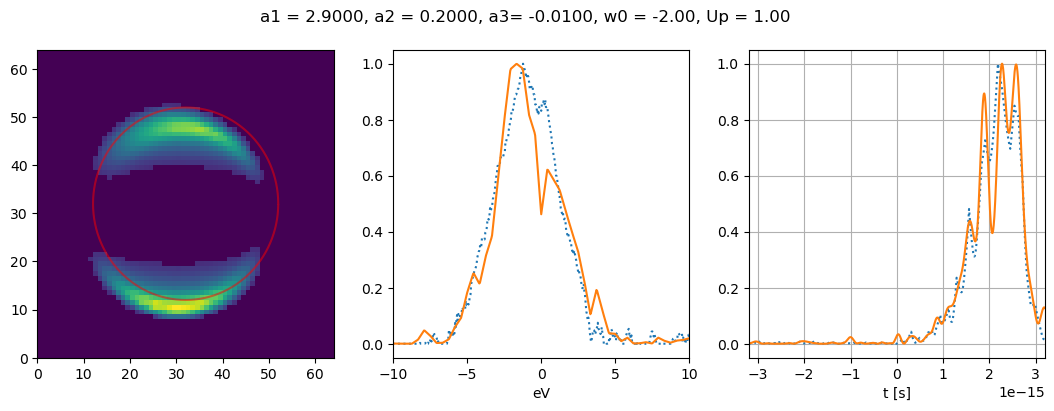

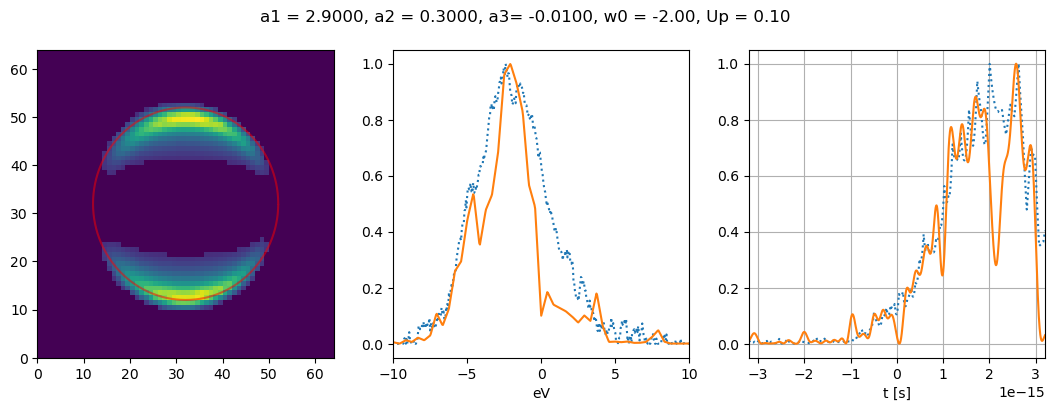

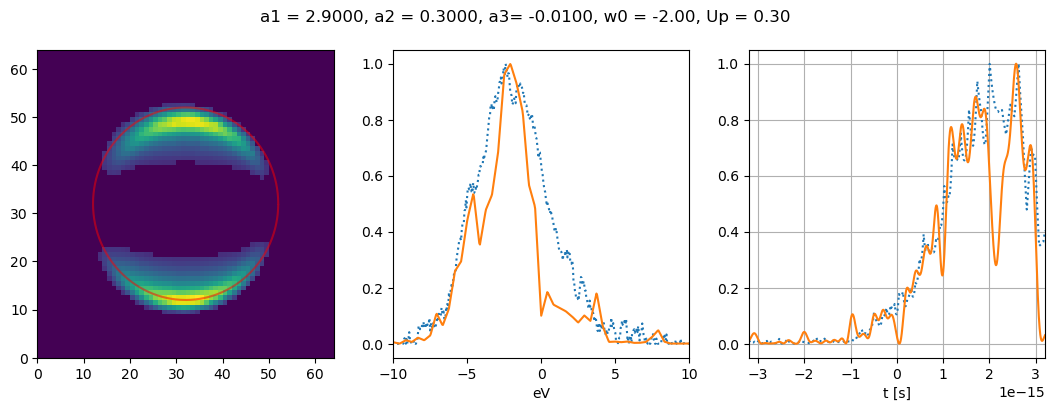

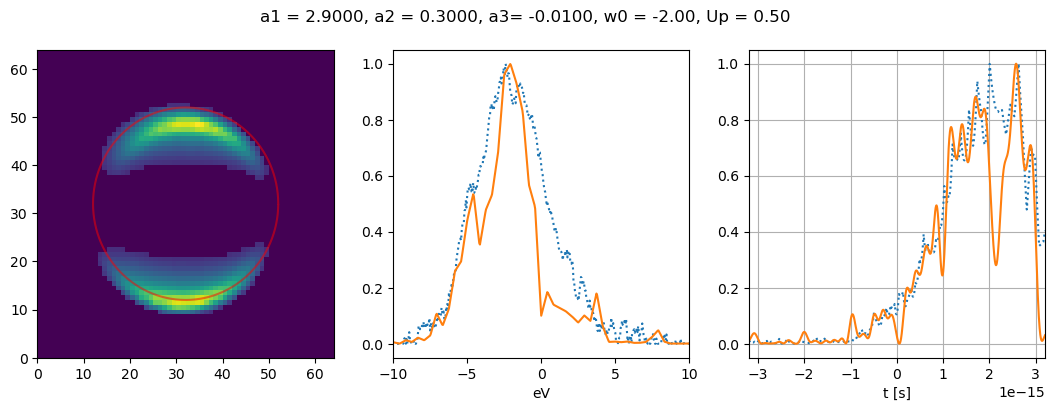

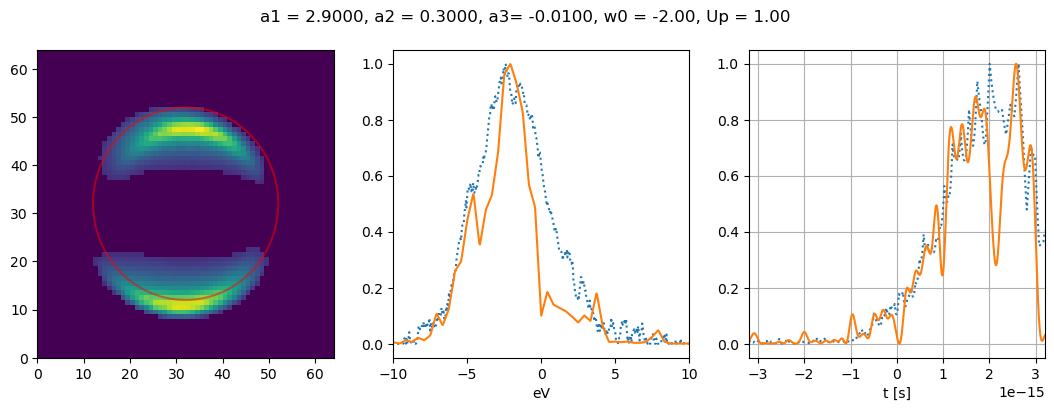

In [12]:
#make training set
specs = []
ms = []
trueQs = []
trueUps = []

a1s = np.linspace(1.75, 2.9, 4)
#a2s = np.linspace(-0.0005, 0.0005, 3)
a2s = [-0.14, 0, 0.14, 0.2, 0.3] #np.hstack((np.linspace(-0.12, 0.3, 3),[0]))
#a3s = [-1, -0.5, 0, -0.5, 1] #np.linspace(-1,1,3)
a3s = [-0.01, -0.005, 0, 0.002, 0.006] #np.hstack((np.linspace(-10,6,5)*1e-3,[0]))
ees = [-2]
sss = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Dec/specs_Feb3_110.npy')
N = 2801
xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis['t_sample'][0])/2 #((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0]))
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
xeV = pix_2_eV(np.arange(len(sss[0])), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)
ts = np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], N)
phis = np.arange(0,360)*np.pi/180


n = 30

for a1 in a1s:
    for a2 in a2s:
        for a3 in a3s:
            #a3 = a3*(0.0005-a2)/10
            #a3 = a3*(np.max(a2s)-np.abs(a2))/100
            for w0 in ees:
                s = sss[n]
                s = s/np.max(s)
                s[s<0] = 0
                s = np.roll(s,21) #this is rolling spectra so w0 is at the center of the array

                for u in range(len(Ups)):
                    Bp_basis = Bps[u]
                    alphw = alphaws[u]
                    alpht = alphats[u]

                    p1 = Point(s, pixpereV = 22, w0 = w0, a1 = a1, a2 = a2, a3 = a3)
                    p1.make_Qs()
                    Q = p1.Qs
                    fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (13,4))
                    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))
                    Msol1 = np.reshape(Msol1,[64,64])
                    Msol1 = Msol1*250/np.max(Msol1)
                    Msol1[Msol1<32] = 0 
                    axs[0].pcolormesh(Msol1)
                    axs[0].plot(32+ 20*np.cos(phis), 32+ 20*np.sin(phis), 'r-', alpha = 0.5)
                    axs[1].plot(xeV+w0, p1.spec, ':')
                    Ew = np.squeeze(np.matmul(Q.T,alphw))
                    EwEw = Ew*Ew.conj()/np.max(np.abs(Ew)**2)
                    f = interpolate.interp1d(eV, EwEw, fill_value = 0, bounds_error = False)
                    EwEw = f(xeV)
                    axs[1].plot(xeV, EwEw)
                    axs[1].set_xlabel('eV')
                    Et = np.squeeze(np.matmul(Q.T,alpht))
                    axs[2].plot(vNaxis['t_sample'], p1.tpreQ/np.max(p1.tpreQ), ':')
                    axs[2].plot(ts, Et*Et.conj()/np.max(np.abs(Et)**2))
                    axs[1].set_xlim(-10,10)
                    axs[2].set_xlim(-3.2e-15,3.2e-15)
                    axs[2].set_xlabel('t [s]')
                    axs[2].grid()
                    plt.suptitle('a1 = %1.4f, a2 = %1.4f, a3= %1.4f, w0 = %1.2f, Up = %1.2f' %(a1,a2,a3,w0,Ups[u]))
                    specs.append(np.real(EwEw))
                    ms.append(Msol1)
                    trueQs.append(Q)
                    trueUps.append(Ups[u])

            n = n+1
            if n > 27: break

In [ ]:
np.save('specs.npy', specs)
np.save('Ms.npy', ms)
np.save('Qs.npy', trueQs)
np.save('Ups.npy', trueUps)

In [13]:
pwd

'/cds/home/p/paris/cVMI'